<a href="https://colab.research.google.com/github/saketkc/pyro-rethinking/blob/master/Chapters/05_Chapter05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter 05 - Multivariate Linear Models

In [ ]:
!pip install torch torchvision pyro-ppl proplot black blackcellmagic

In [2]:
%load_ext blackcellmagic
import warnings

import pandas as pd
import proplot as plot
import pyro
import pyro.distributions as dist
import pyro.infer
import pyro.ops.stats as stats
import pyro.optim
import seaborn as sns
import torch
import torch.distributions.constraints as constraints
import torch.tensor as tensor
from pyro.contrib.autoguide import AutoLaplaceApproximation

warnings.filterwarnings("ignore")
%pylab inline
pyro.set_rng_seed(42)

plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["font.weight"] = "bold"

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


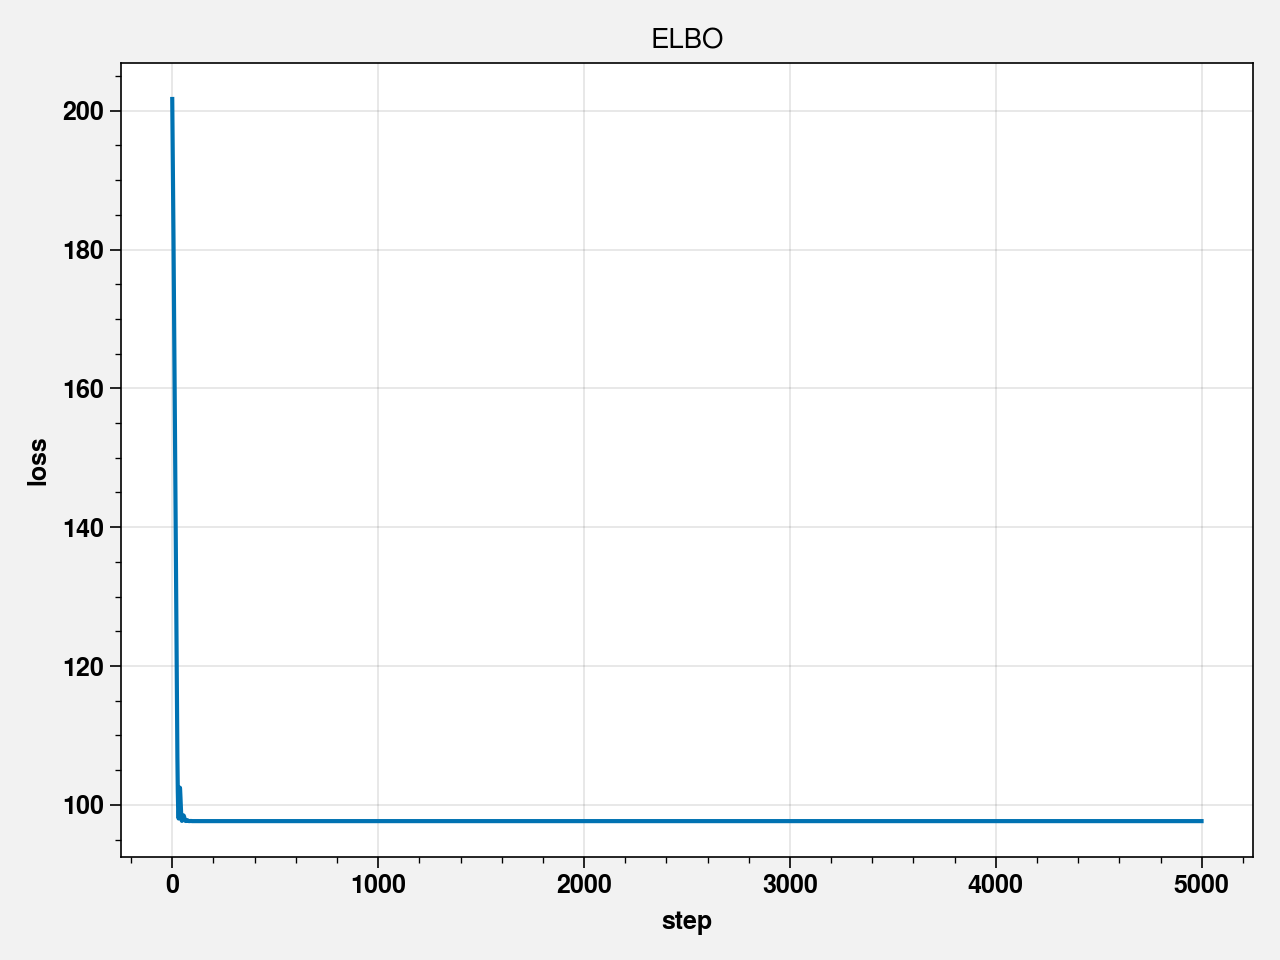

In [3]:
waffle_divorce = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv", sep=";")
d = waffle_divorce
# standardize predictor

d['MedianAgeMarriage_s'] = (d.MedianAgeMarriage - d.MedianAgeMarriage.mean())/d.MedianAgeMarriage.std()

def model51(MedianAgeMarriage_s):
  
  a = pyro.sample("a", dist.Normal(tensor(10.), tensor(10.)))
  bA = pyro.sample("bA", dist.Normal(tensor(0.), tensor(1.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(50.)))
  mu = a + bA * MedianAgeMarriage_s

  divorce = pyro.sample("divorce", dist.Normal(mu, sigma))
  return divorce 

def link(laplace_guide, data, num_samples):
  pred = pyro.infer.Predictive(laplace_guide, num_samples=num_samples)
  samples = pred.get_samples()
  mu = samples["bA"].detach().reshape((num_samples,1))*data.reshape(1, data.shape[0]) + samples["a"].detach().reshape((num_samples,1))
  return mu

divorce = tensor(d.Divorce, dtype=torch.float)
MedianAgeMarriage_s = tensor(d['MedianAgeMarriage_s'], dtype=torch.float)

conditioned51 = pyro.condition(model51, data={"divorce": divorce})
guide51 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned51)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned51,
    guide=guide51,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(MedianAgeMarriage_s) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guide51 = guide51.laplace_approximation(MedianAgeMarriage_s)
pred51 = pyro.infer.Predictive(laplace_guide51, num_samples=1000)  

# Code 5.2

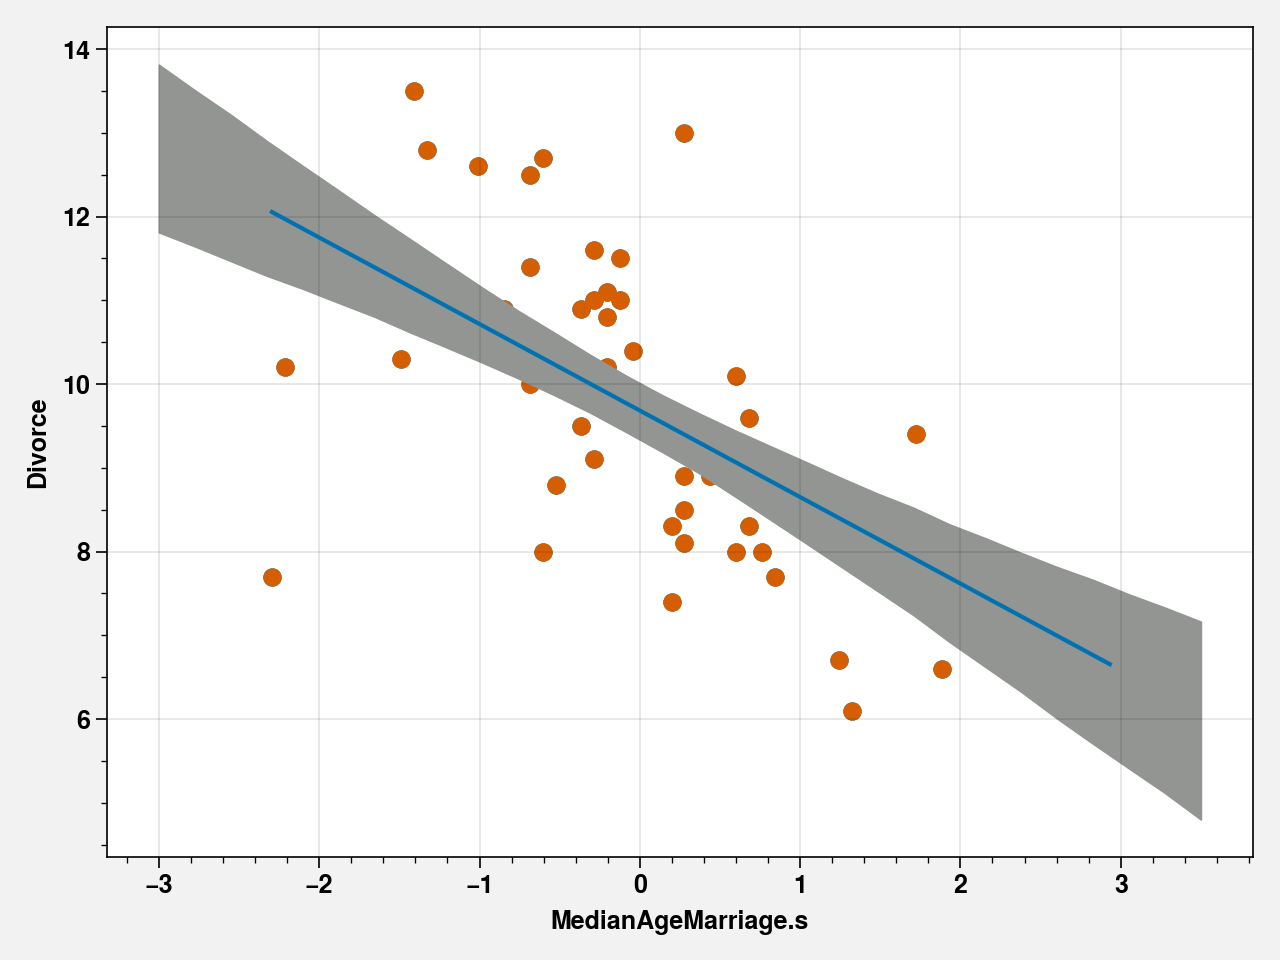

In [4]:
mam_seq = torch.linspace(-3., 3.5, steps=30)
mu = link(laplace_guide51, mam_seq, 1000)
mu_PI = stats.pi(mu, dim=0, prob=0.89)

fig, ax = plt.subplots()
ax.scatter(waffle_divorce['MedianAgeMarriage_s'], waffle_divorce['Divorce'])

x = waffle_divorce['MedianAgeMarriage_s'].sort_values()
y = tensor(waffle_divorce['MedianAgeMarriage_s'].sort_values()) * pred51.get_samples()["bA"].detach().mean() + pred51.get_samples()["a"].detach().mean()
ax.scatter(waffle_divorce['MedianAgeMarriage_s'], waffle_divorce['Divorce'])
ax.plot(x,y)
ax.fill_between(mam_seq, mu_PI[0], mu_PI[1], color='gray')
ax.set_xlabel("MedianAgeMarriage.s")
ax.set_ylabel('Divorce')
fig.tight_layout()

# Code 5.3


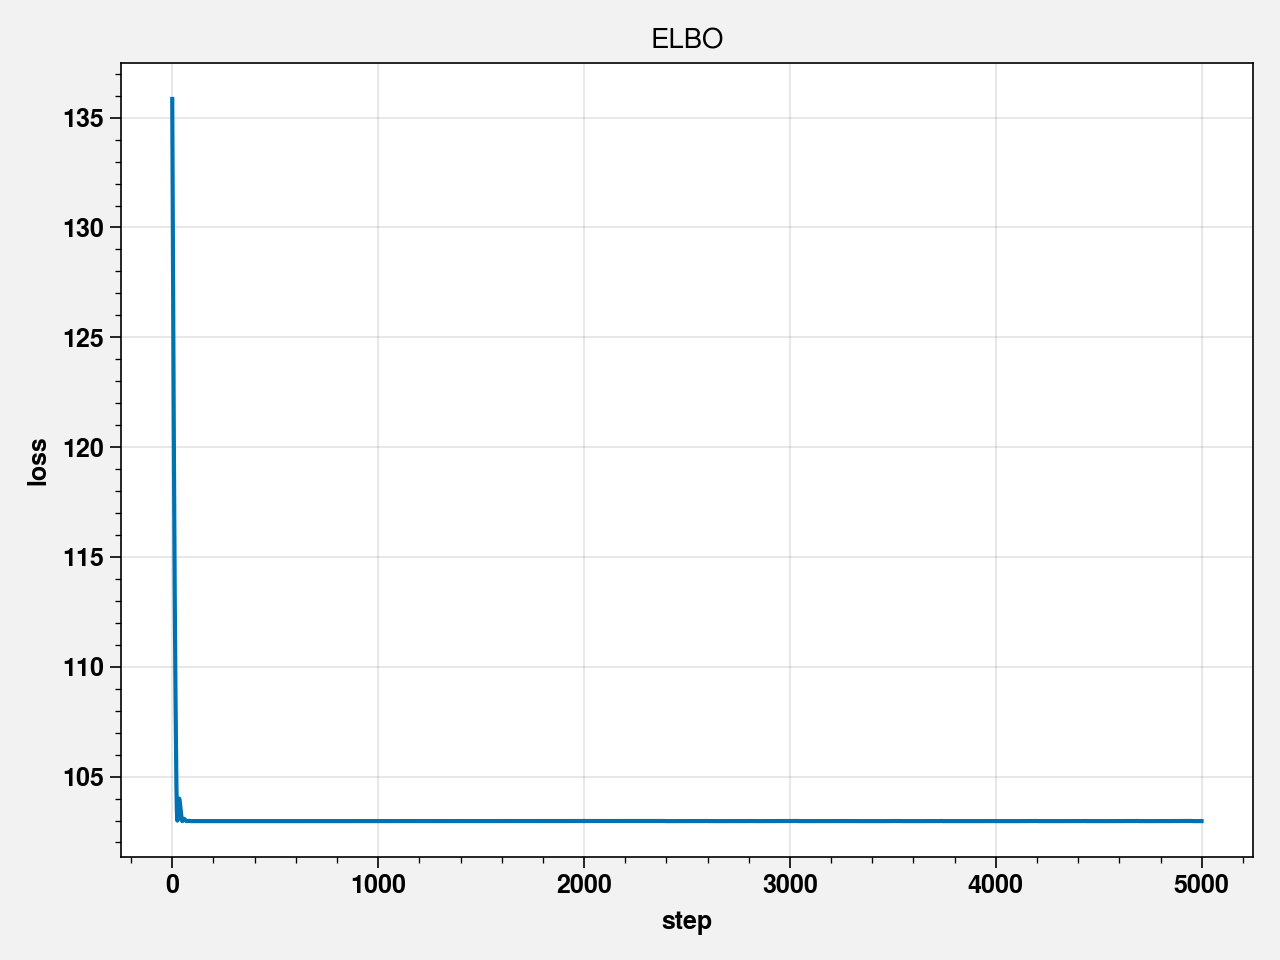

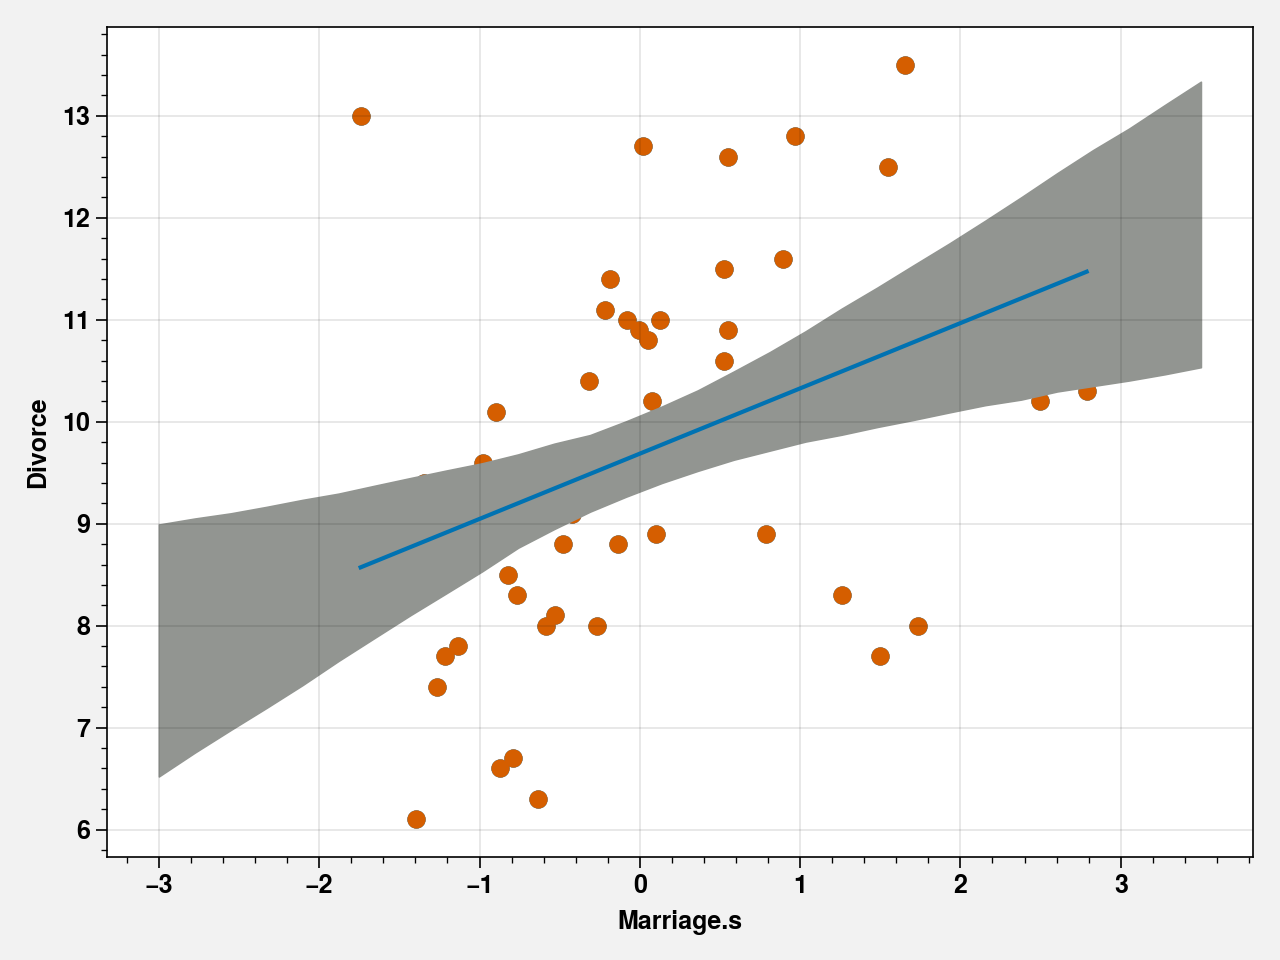

In [5]:
d['Marriage_s'] = (d.Marriage - d.Marriage.mean())/d.Marriage.std()

def model52(Marriage_s):
  
  a = pyro.sample("a", dist.Normal(tensor(10.), tensor(10.)))
  bR = pyro.sample("bR", dist.Normal(tensor(0.), tensor(1.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))
  mu = a + bR * Marriage_s

  divorce = pyro.sample("divorce", dist.Normal(mu, sigma))
  return divorce 

def link(laplace_guide, data, num_samples):
  pred = pyro.infer.Predictive(laplace_guide, num_samples=num_samples)
  samples = pred.get_samples()
  mu = samples["bR"].detach().reshape((num_samples,1))*data.reshape(1, data.shape[0]) + samples["a"].detach().reshape((num_samples,1))
  return mu

divorce = tensor(d.Divorce, dtype=torch.float)
Marriage_s = tensor(d['Marriage_s'], dtype=torch.float)

conditioned52 = pyro.condition(model52, data={"divorce": divorce})
guide52 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned52)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned52,
    guide=guide52,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(Marriage_s) for t in range(num_steps)]
plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")
plt.tight_layout()
laplace_guide52 = guide52.laplace_approximation(Marriage_s)
pred52 = pyro.infer.Predictive(laplace_guide52, num_samples=1000)  


mam_seq = torch.linspace(-3., 3.5, steps=30)
mu = link(laplace_guide52, mam_seq, 1000)
mu_PI = stats.pi(mu, dim=0, prob=0.89)

fig, ax = plt.subplots()
ax.scatter(waffle_divorce['Marriage_s'], waffle_divorce['Divorce'])

x = waffle_divorce['Marriage_s'].sort_values()
y = tensor(waffle_divorce['Marriage_s'].sort_values()) * pred52.get_samples()["bR"].detach().mean() + pred52.get_samples()["a"].detach().mean()
ax.scatter(waffle_divorce['Marriage_s'], waffle_divorce['Divorce'])
ax.plot(x,y)
ax.fill_between(mam_seq, mu_PI[0], mu_PI[1], color='gray')
ax.set_xlabel("Marriage.s")
ax.set_ylabel('Divorce')
fig.tight_layout()

# Code 5.4

In [6]:


def model53(Marriage_s, MedianAgeMarriage_s):
  
  a = pyro.sample("a", dist.Normal(tensor(10.), tensor(10.)))
  bA = pyro.sample("bA", dist.Normal(tensor(0.), tensor(1.)))
  bR = pyro.sample("bR", dist.Normal(tensor(0.), tensor(1.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))
  mu = a + bR * Marriage_s + bA * MedianAgeMarriage_s

  divorce = pyro.sample("divorce", dist.Normal(mu, sigma))
  return divorce 

divorce = tensor(d.Divorce, dtype=torch.float)
Marriage_s = tensor(d['Marriage_s'], dtype=torch.float)
MedianAgeMarriage_s = tensor(d['MedianAgeMarriage_s'], dtype=torch.float)

conditioned53 = pyro.condition(model53, data={"divorce": divorce})
guide53 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned53)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned53,
    guide=guide53,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(Marriage_s, MedianAgeMarriage_s) for t in range(num_steps)]
laplace_guide53 = guide53.laplace_approximation(Marriage_s, MedianAgeMarriage_s)
pred53 = pyro.infer.Predictive(laplace_guide53, num_samples=1000)  
samples53 = pred53.get_samples()
post53 = summary(samples53) 
pred53

Predictive(
  (model): AutoMultivariateNormal()
)

# Code 5.5

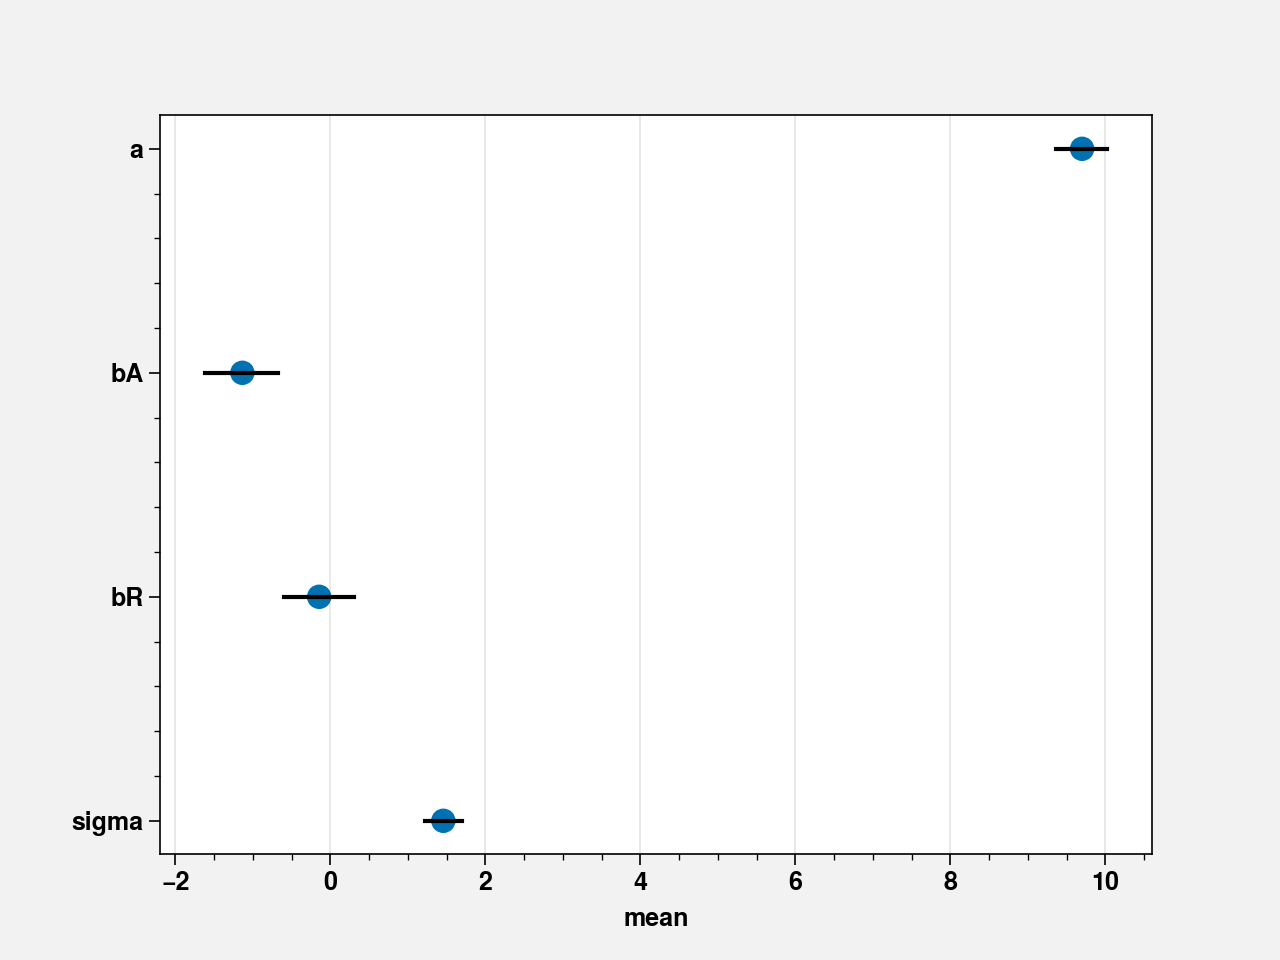

In [7]:
precis = summary(pred53.get_samples())
precis = precis.drop(columns = ["_AutoMultivariateNormal_latent"]).T
fig, ax = plt.subplots()
sns.pointplot(precis["mean"], precis.index, join=False, ax=ax)
for i, param in enumerate(precis.index):
  sns.lineplot(np.hstack(precis.loc[param, ["5.0%", "95.0%"]].values), [i, i], color="k", ax=ax)

# Code 5.6

In [8]:
def model54(MedianAgeMarriage_s):
  
  a = pyro.sample("a", dist.Normal(tensor(0.), tensor(10.)))
  b = pyro.sample("bA", dist.Normal(tensor(0.), tensor(1.)))  
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))
  mu = a + b * MedianAgeMarriage_s

  marriage_s = pyro.sample("marriage", dist.Normal(mu, sigma))
  return marriage_s

conditioned54 = pyro.condition(model54, data={"marriage": Marriage_s})
guide54 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned54)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned54,
    guide=guide54,
    optim=pyro.optim.Adam({"lr": 0.1}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(MedianAgeMarriage_s) for t in range(num_steps)]
laplace_guide54 = guide54.laplace_approximation(MedianAgeMarriage_s)
pred54 = pyro.infer.Predictive(laplace_guide54, num_samples=1000)  
precis = summary(pred54.get_samples()) 

# Code 5.7

In [9]:
mu = precis.loc["mean", "a"]  + precis.loc["mean", "bA"]*waffle_divorce['MedianAgeMarriage_s']
m_resid = waffle_divorce['MedianAgeMarriage_s'] - mu

# Code 5.8


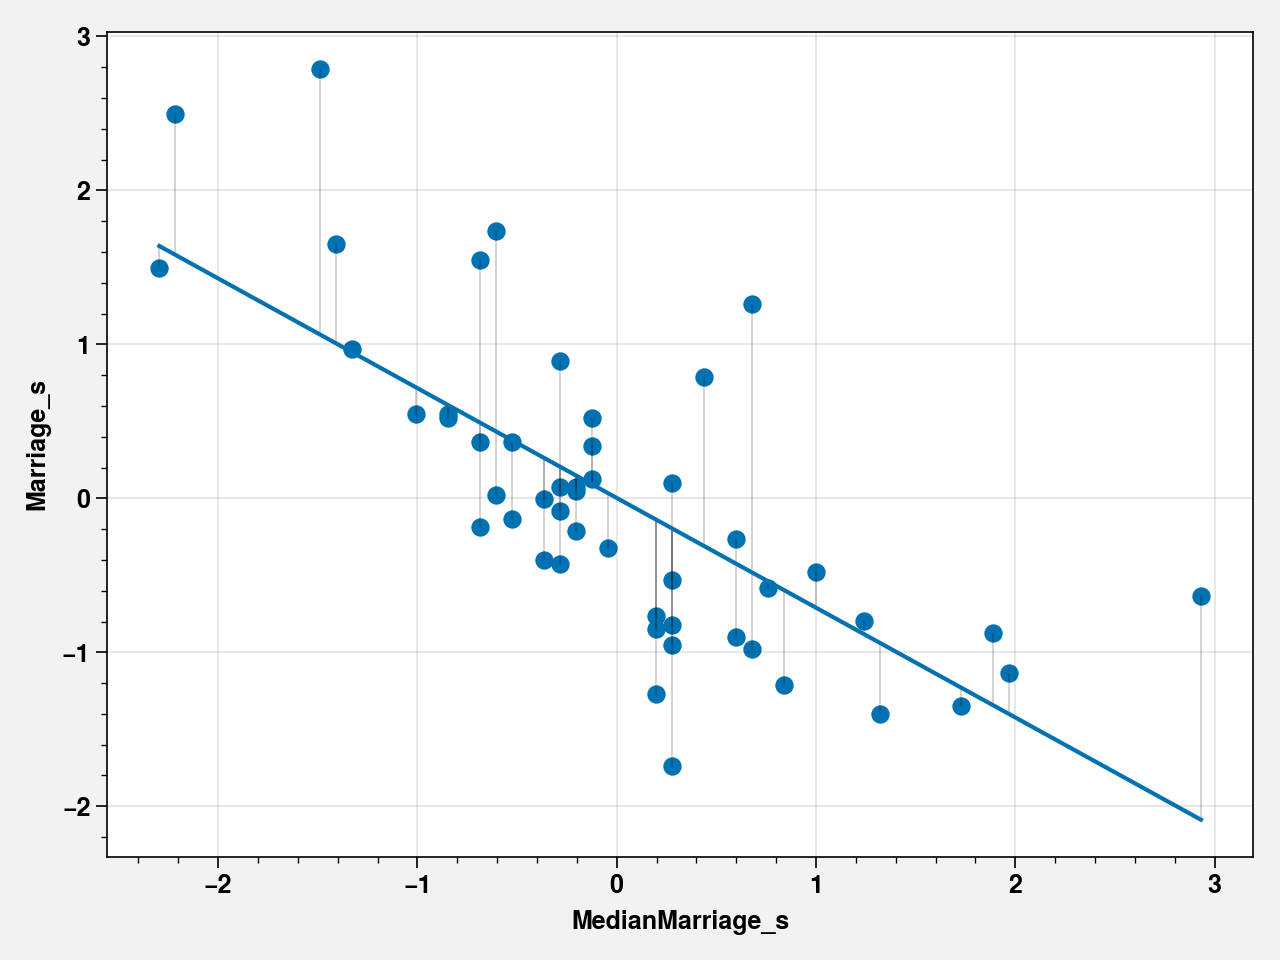

In [10]:
fig, ax = plt.subplots()
ax.scatter(waffle_divorce['MedianAgeMarriage_s'], waffle_divorce['Marriage_s'])

x = waffle_divorce['MedianAgeMarriage_s'].sort_values().unique()
y = precis.loc["mean", "a"]  + precis.loc["mean", "bA"]*x

ax.plot(x,y)

for i in range(len(m_resid)):
  x = waffle_divorce['MedianAgeMarriage_s'][i]
  y = waffle_divorce['Marriage_s'][i]
  sns.lineplot([x, x], [mu[i], y], color="k", alpha=1)
ax.set_xlabel('MedianMarriage_s')
ax.set_ylabel('Marriage_s')
fig.tight_layout()

# Code 5.9

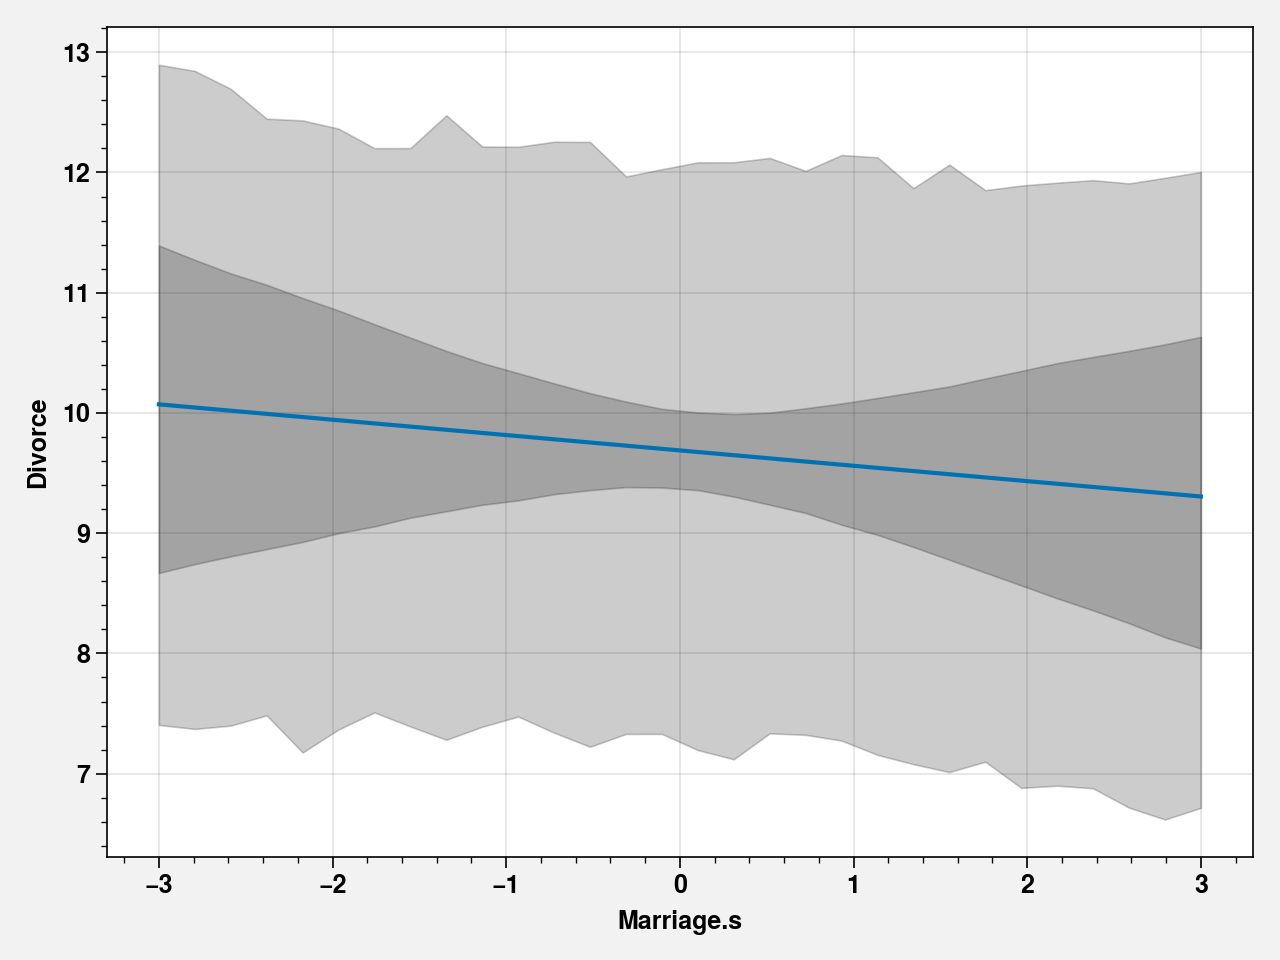

In [11]:
def sim(post, A, R, num_samples=1000):
  mu = post["bR"].detach().reshape((num_samples,1))*R.reshape(1, R.shape[0])
  mu += post["a"].detach().reshape((num_samples,1)) 
  mu += post["bA"].detach().reshape((num_samples,1))*A  
  sigma = post["sigma"].reshape(num_samples,1)
  divorce = dist.Normal(mu, 
                        sigma).sample()
  return divorce


def link(samples, A, R, num_samples=1000):

  mu = samples["bR"].detach().reshape((num_samples,1))*R.reshape(1, R.shape[0])
  mu += samples["a"].detach().reshape((num_samples,1)) 
  mu += samples["bA"].detach().reshape((num_samples,1))*A  
  return mu

A_avg = d['MedianAgeMarriage_s'].mean()
R_seq = torch.linspace(-3., 3., steps=30)

samples = samples53
mu = link(samples, A_avg, R_seq, num_samples=1000)
mu_mean = mu.mean(0)

mu_PI = stats.pi(mu, dim=0, prob=0.89)

R_sim = sim(samples, A_avg, R_seq)
R_PI = stats.pi(R_sim, dim=0, prob=0.89)


fig, ax = plt.subplots()
sns.lineplot(R_seq.numpy(), mu_mean.numpy(), ax=ax)
ax.fill_between(R_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
ax.fill_between(R_seq, R_PI[0], R_PI[1], color="k", alpha=0.2)
ax.set_xlabel('Marriage.s')
ax.set_ylabel('Divorce')
fig.tight_layout()

# Code 5.10

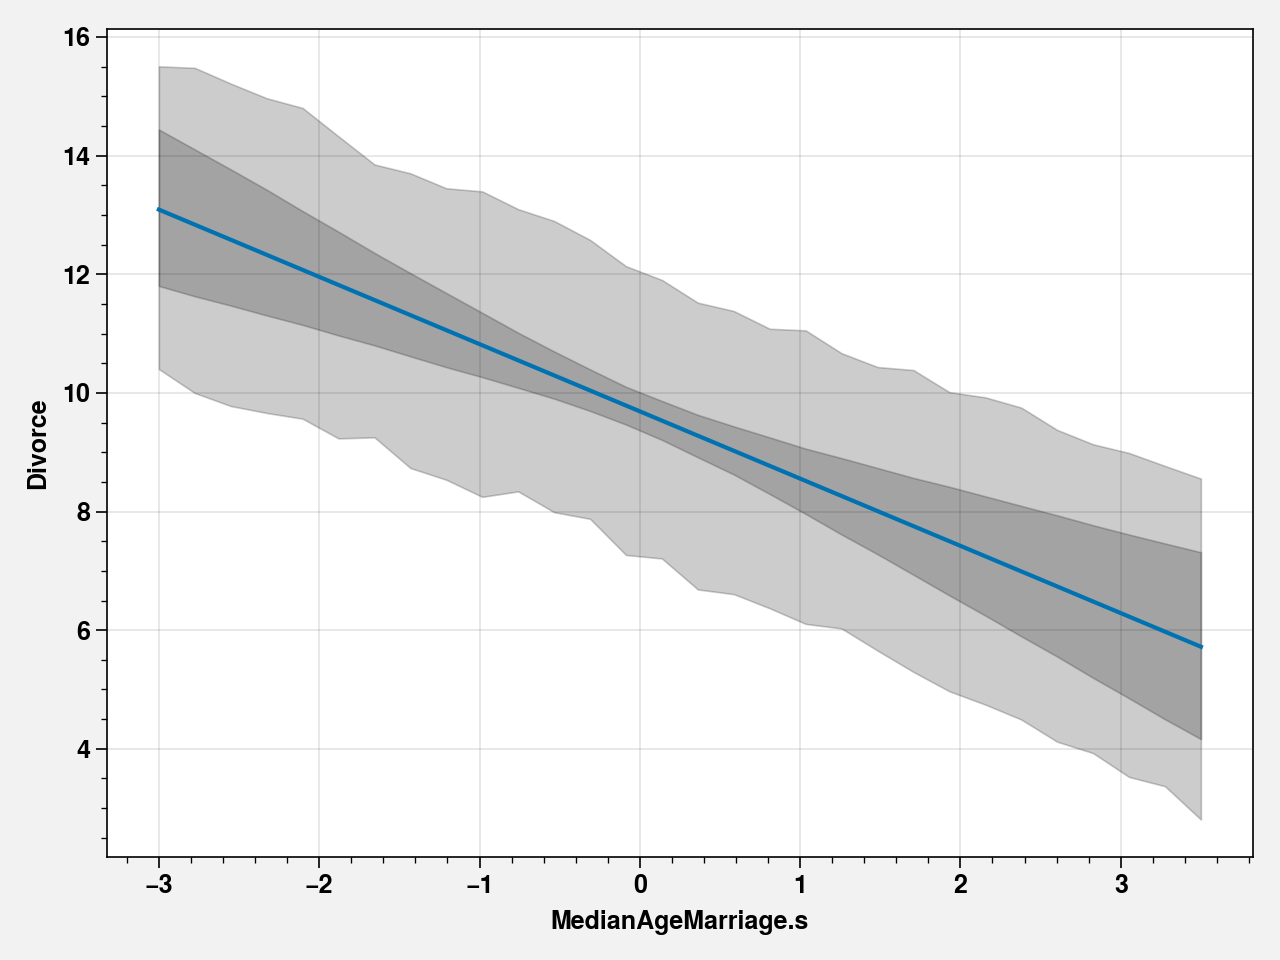

In [12]:
def sim(post, A, R, num_samples=1000):
  
  mu = post["bA"].detach().reshape((num_samples,1))*A.reshape(1, A.shape[0]) 
  mu += post["bR"].detach().reshape((num_samples,1))*R
  mu += post["a"].detach().reshape((num_samples,1)) 
  
  sigma = post["sigma"].reshape(num_samples,1)
  divorce = dist.Normal(mu, 
                        sigma).sample()
  return divorce


def link(samples, A, R, num_samples=1000):

  mu = samples["bA"].detach().reshape((num_samples,1))*A.reshape(1, A.shape[0])    
  mu += samples["a"].detach().reshape((num_samples,1)) 
  mu += samples["bR"].detach().reshape((num_samples,1))*R
  return mu


R_avg = d['Marriage_s'].mean()
A_seq = torch.linspace(-3., 3.5, steps=30)

samples = samples53
mu = link(samples, A_seq, R_avg, num_samples=1000)
mu_mean = mu.mean(0)
mu_PI = stats.pi(mu, dim=0, prob=0.89)

A_sim = sim(samples, A_seq, R_avg)
A_PI = stats.pi(A_sim, dim=0, prob=0.89)


fig, ax = plt.subplots()
sns.lineplot(A_seq.numpy(), mu_mean.numpy(), ax=ax)
ax.fill_between(A_seq, mu_PI[0], mu_PI[1], color="k", alpha=0.2)
ax.fill_between(A_seq, A_PI[0], A_PI[1], color="k", alpha=0.2)
ax.set_xlabel('MedianAgeMarriage.s')
ax.set_ylabel('Divorce')
fig.tight_layout()

# Code 5.11

In [13]:
def sim(post, A, R, num_samples=1000):
  
  mu = post["bA"].detach().reshape((num_samples,1))*A.reshape(1, A.shape[0]) 
  mu += post["bR"].detach().reshape((num_samples,1))*R.reshape(1, R.shape[0]) 
  mu += post["a"].detach().reshape((num_samples,1)) 
  
  sigma = post["sigma"].reshape(num_samples,1)
  divorce = dist.Normal(mu, 
                        sigma).sample()
  return divorce


#mu = post53.loc["mean", "a"]  + post53.loc["mean", "bA"]*waffle_divorce['MedianAgeMarriage_s'] + post53.loc["mean", "bR"]*waffle_divorce['Marriage_s']
#mu = tensor(mu, dtype=torch.float)
num_samples = 1000
A = tensor(waffle_divorce['MedianAgeMarriage_s'], dtype=torch.float)
R = tensor(waffle_divorce['Marriage_s'], dtype=torch.float)
mu = samples["bA"].detach().reshape((num_samples,1))*A.reshape(1, A.shape[0]) 
mu += samples["bR"].detach().reshape((num_samples,1))*R.reshape(1, R.shape[0]) 
mu += samples["a"].detach().reshape((num_samples,1)) 

mu_mean = mu.mean(0)

mu_PI = stats.pi(mu, dim=0, prob=0.89)

divorce_sim = sim(samples, waffle_divorce['MedianAgeMarriage_s'].values, waffle_divorce['Marriage_s'].values)
divorce_PI = stats.pi(divorce_sim, dim=0, prob=0.89)


# Code 5.12

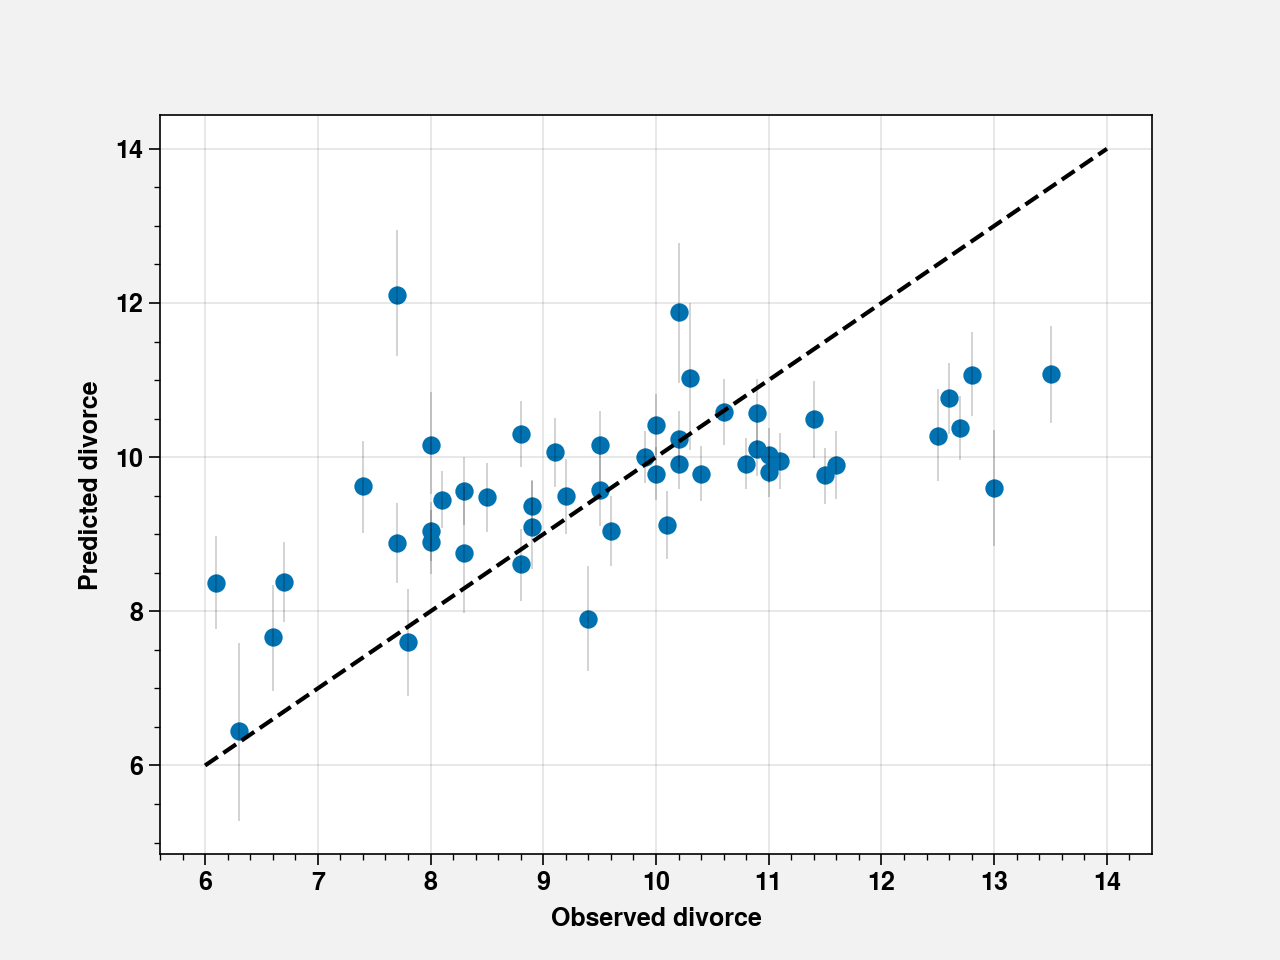

In [14]:
fig, ax = plt.subplots()
ax.scatter(d.Divorce, mu_mean)
ax.set_xlabel('Observed divorce')
ax.set_ylabel('Predicted divorce')
x = torch.linspace(6, 14, 101)
sns.lineplot(x, x, color="k", ax=ax)
ax.lines[-1].set_linestyle("--")
for i in range(d.shape[0]):
    sns.lineplot(divorce[i].repeat(2), mu_PI[:, i], color="k", ax=ax)

# Code 5.13

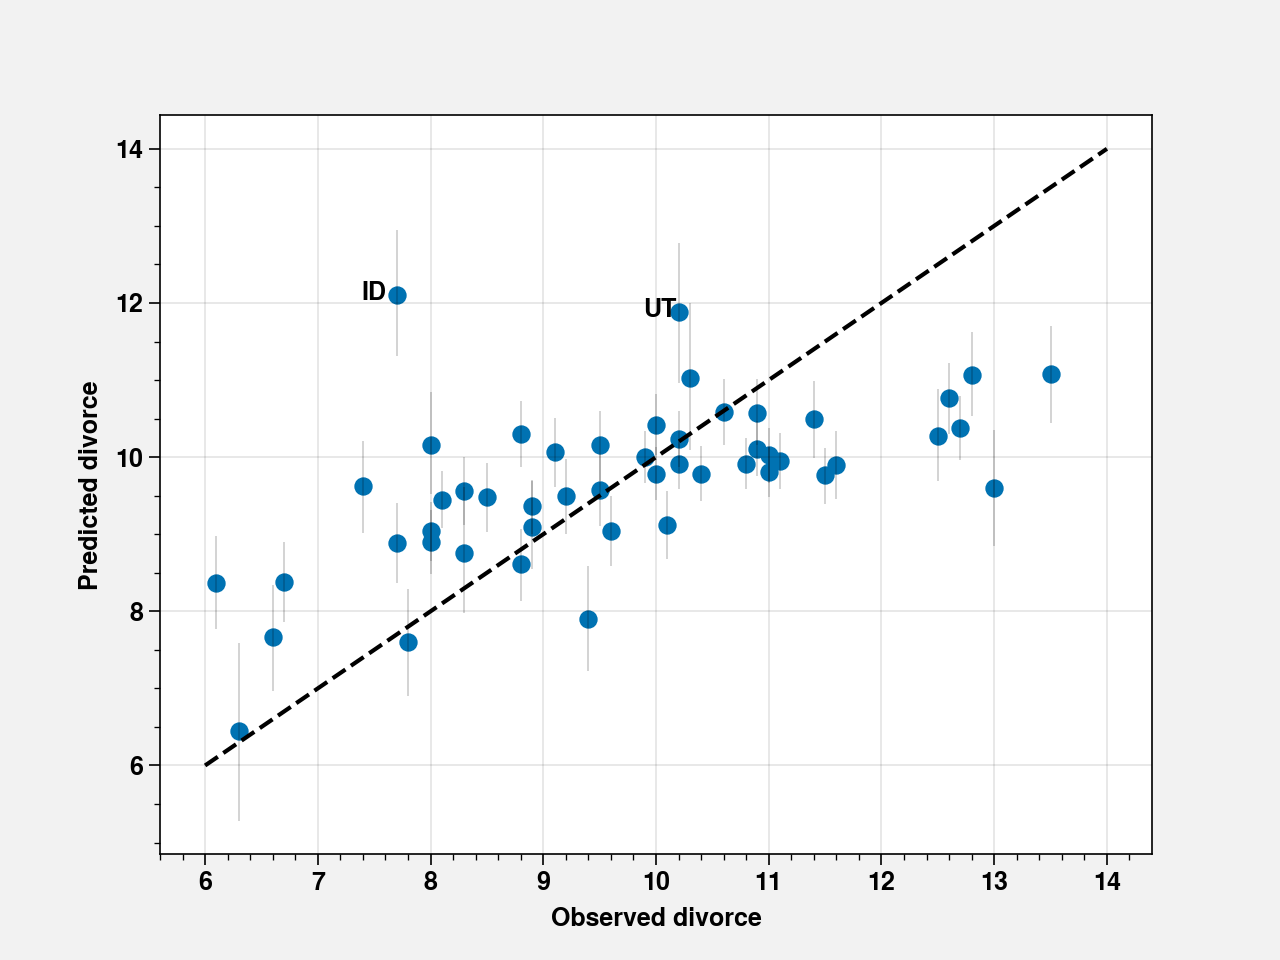

In [15]:
identify = mu_mean.sort(descending=True)[1][:2].numpy()
for i in identify:
  ax.annotate(d["Loc"][i], (divorce[i].numpy(), mu_mean[i].numpy()), xytext=(-35, -5),
              textcoords="offset pixels")
fig

# Ccode 5.14

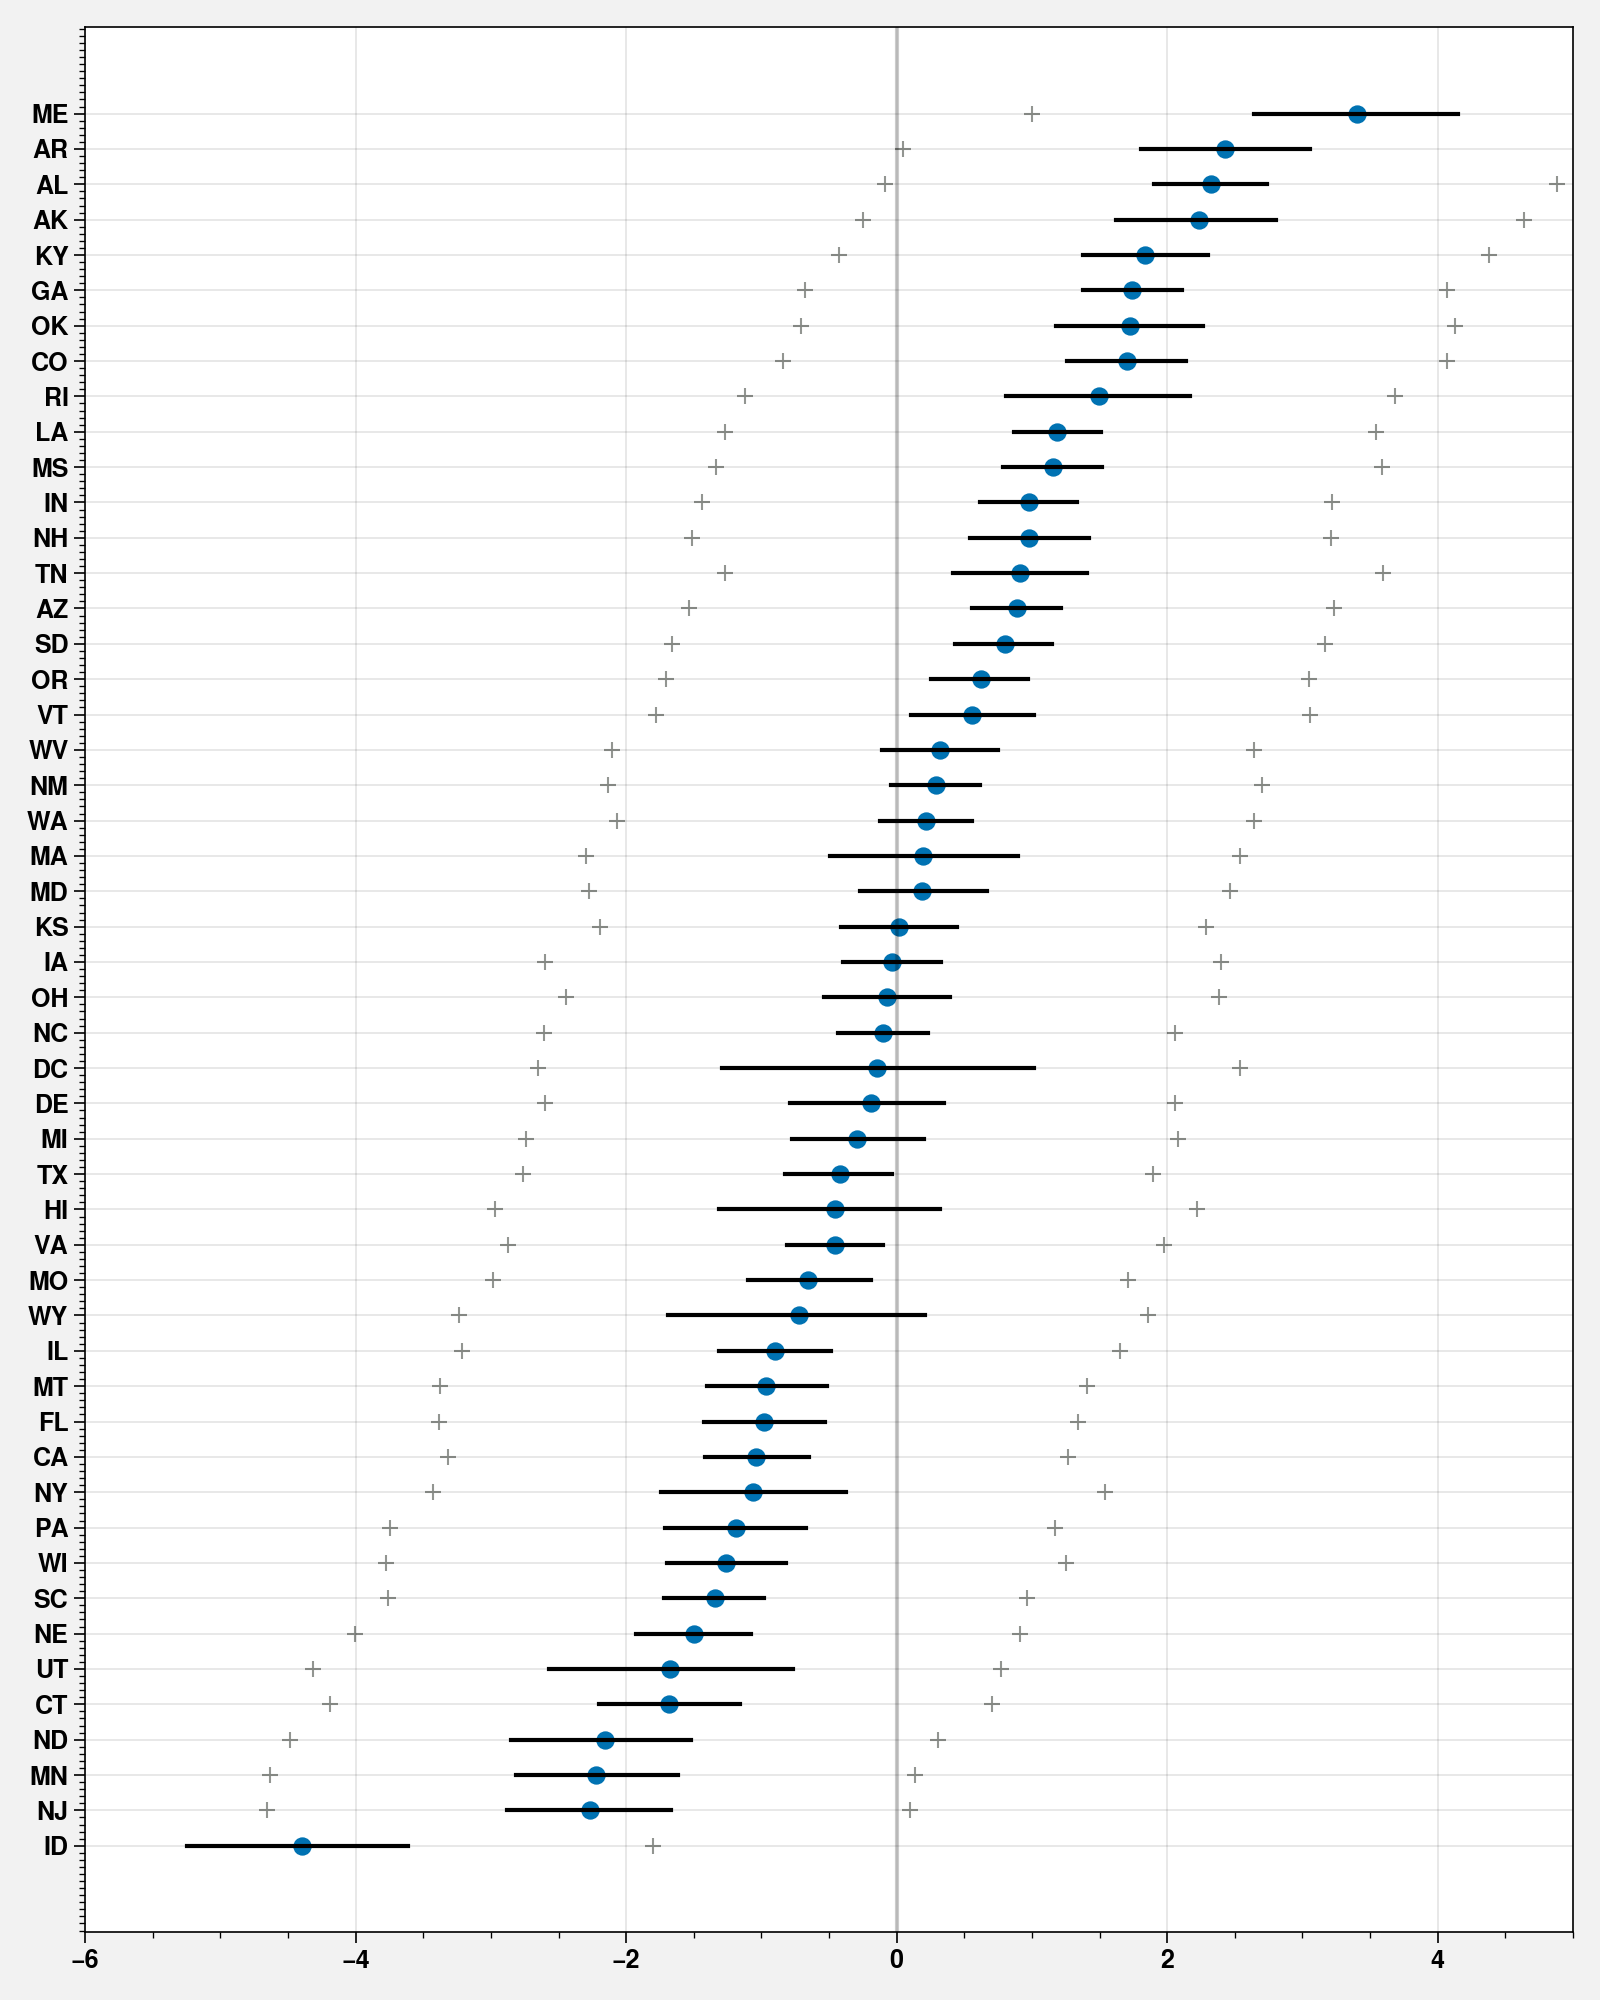

In [16]:
divorce_resid = tensor(d.Divorce) - mu_mean
divorce_resid = divorce_resid.numpy()
o = divorce_resid.argsort()

fig, ax = plt.subplots(figsize=(8, 10))
ax.scatter(divorce_resid[o], d.Loc[o])
ax.set(xlim=(-6, 5))
ax.axvline(x=0, c="k", alpha=0.2)
for i in range(d.shape[0]):
    j = o[i]
    sns.lineplot(divorce[j] - mu_PI[:, j], [i, i], color="k", ax=ax)
    sns.scatterplot(divorce[j] - divorce_PI[:, j], [i, i], color="gray", marker="+", ax=ax)
fig.tight_layout()

# Code 5.15

In [17]:
N = 100
x_real = dist.Normal(0,1).rsample(torch.Size([N]))
x_spur = dist.Normal(x_real,1).rsample(torch.Size([N]))
y = dist.Normal(x_real,1).rsample(torch.Size([N]))
d = pd.DataFrame([x_real.numpy(), x_spur.numpy(),  y.numpy()]).T
d.columns = ["x_real", "x_spur", "y"]

# Code 5.16


In [3]:
milk_df = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv", sep=";")
d = milk_df 
d

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


# Code 5.17


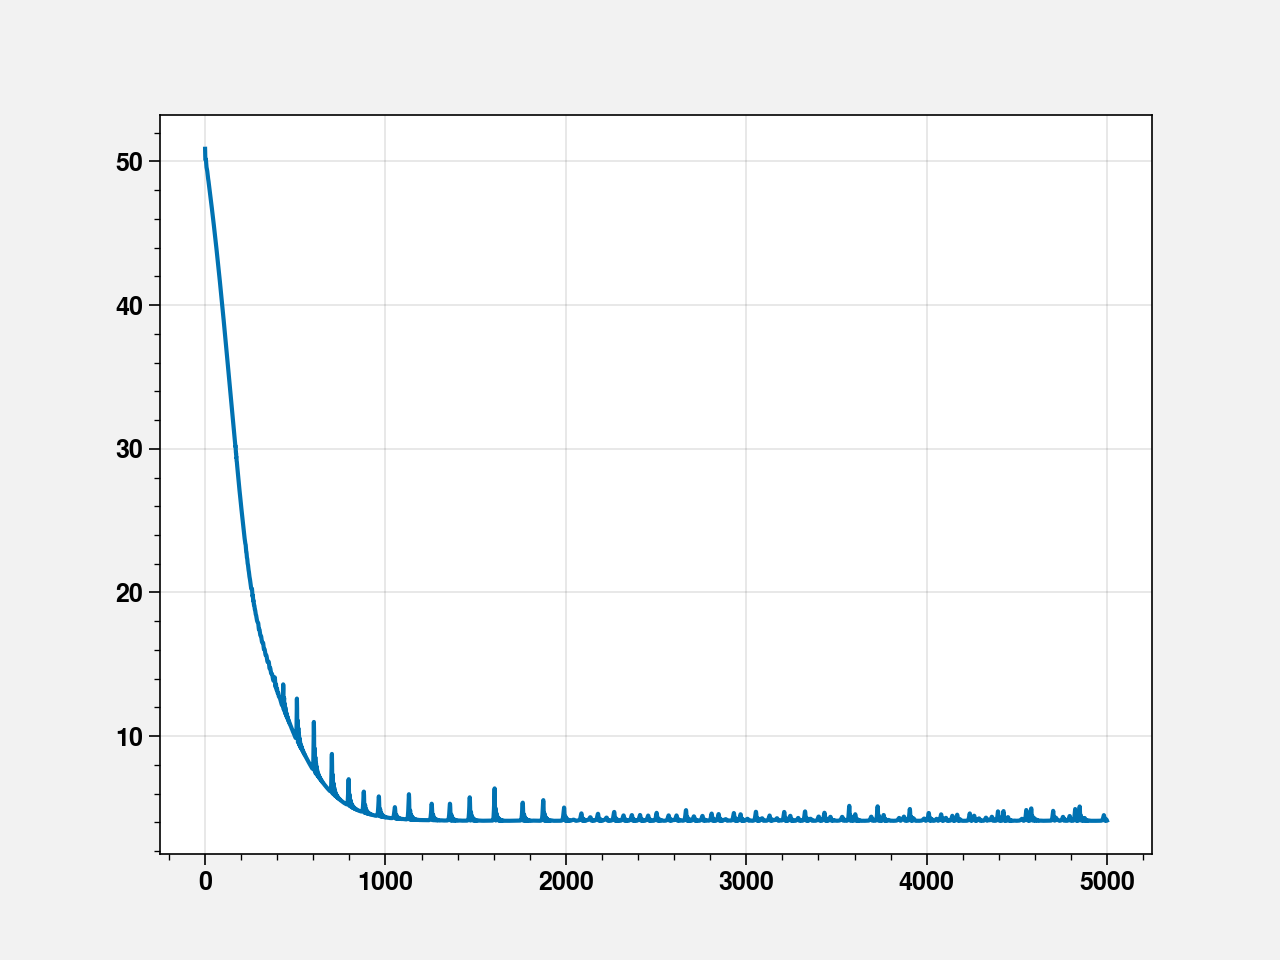

In [23]:
def model55(neocortex_perc):
  a = pyro.sample("a", dist.Normal(tensor(0.), tensor(100.)))
  bn = pyro.sample("bn", dist.Normal(tensor(0.), tensor(1.)))  
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))
  mu = a + bn * neocortex_perc
  kcal_per_g = pyro.sample("kcal_per_g", dist.Normal(mu.float(), sigma.float()))
  return kcal_per_g

dcc = d.dropna()
kcal_per_g = tensor(dcc['kcal.per.g'], dtype=torch.float)
neocortex_perc = tensor(dcc['neocortex.perc'], dtype=torch.float)

conditioned55 = pyro.condition(model55, data={"kcal_per_g": kcal_per_g})
guide55 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned55)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned55,
    guide=guide55,
    optim=pyro.optim.Adam({"lr": 0.01}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(neocortex_perc.float()) for t in range(num_steps)]
plt.plot(losses)


# Code 5.18

In [24]:
d['neocortex.perc']

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

# Code 5.19

In [4]:
dcc = d.dropna()

# Code 5.20

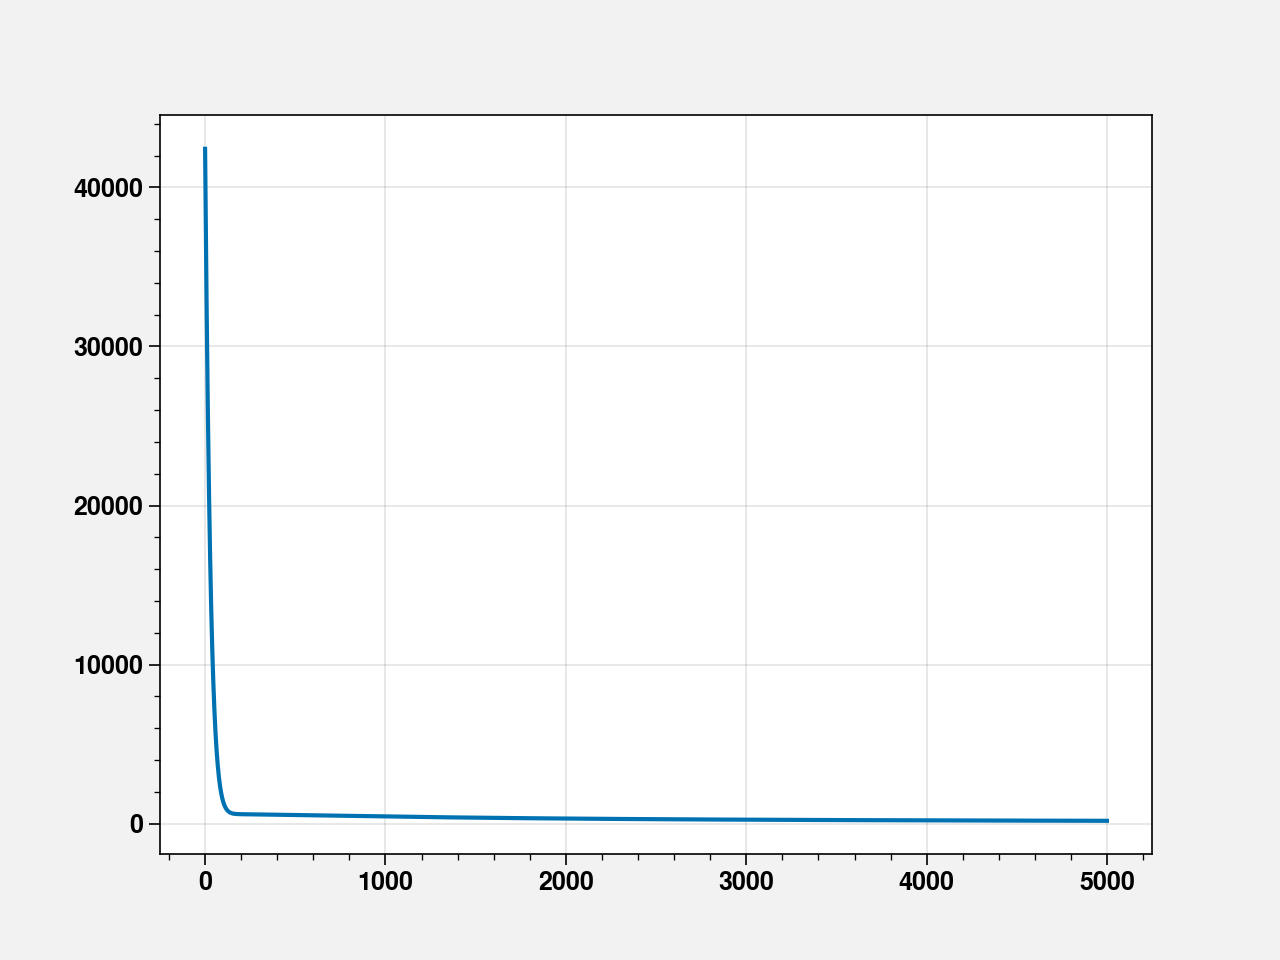

In [28]:
def model55(data):
  a = pyro.sample("a", dist.Normal(tensor(0.), tensor(100.)))
  bn = pyro.sample("bn", dist.Normal(tensor(0.), tensor(1.)))  
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(1.)))
  mu = a + bn * data
  kcal_per_g = pyro.sample("kcal_per_g", dist.Normal(mu, sigma))
  return kcal_per_g

kcal_per_g = tensor(dcc['kcal.per.g'], dtype=torch.float)
neocortex_perc = tensor(dcc['neocortex.perc'], dtype=torch.float)

conditioned55 = pyro.condition(model55, data={"kcal_per_g": kcal_per_g})
guide55 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned55)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned55,
    guide=guide55,
    optim=pyro.optim.Adam({"lr": 0.005}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(neocortex_perc.float()) for t in range(num_steps)]
plt.plot(losses)

laplace_guide55 = guide55.laplace_approximation(neocortex_perc)
pred55 = pyro.infer.Predictive(laplace_guide55, num_samples=1000)  
precis55 = summary(pred55.get_samples()) 

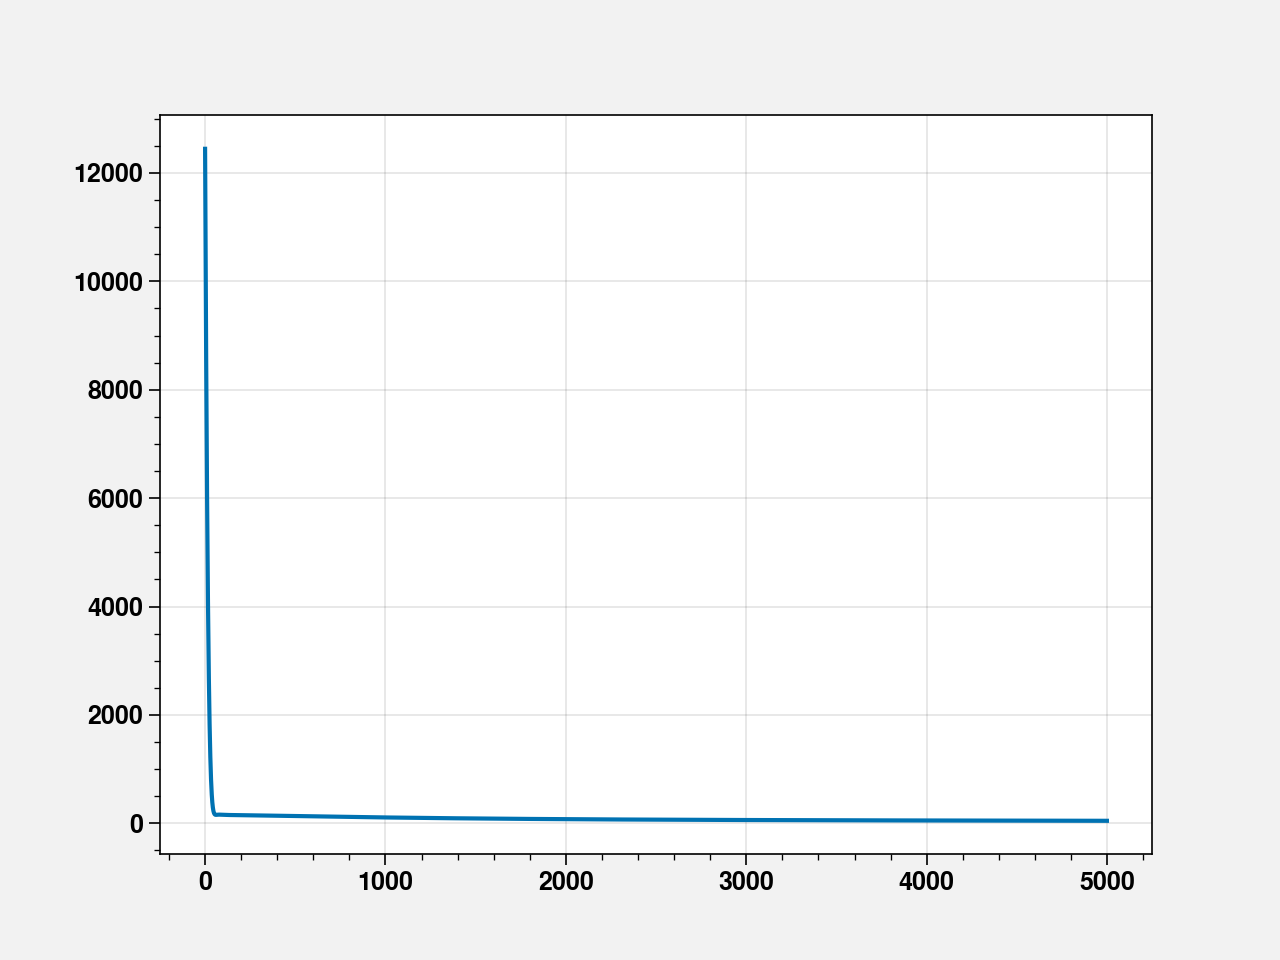

In [40]:
def model(x, y):
    a = pyro.sample("a", dist.Normal(tensor(0.), tensor(100.)))
    bn = pyro.sample("bn", dist.Normal(tensor(0.), tensor(1.)))
    mu = a + bn * x
    sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(1.)))
    with pyro.plate("plate"):
        pyro.sample("kcal_per_g", dist.Normal(mu, sigma), obs=y)

def model55(x,y):
  a = pyro.sample("a", dist.Normal(tensor(0.), tensor(100.)))
  bn = pyro.sample("bn", dist.Normal(tensor(0.), tensor(1.)))  
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(1.)))
  mu = a + bn * x
  kcal_per_g = pyro.sample("kcal_per_g", dist.Normal(mu, sigma))#, obs=y)
  return kcal_per_g

kcal_per_g = tensor(dcc['kcal.per.g'], dtype=torch.float).float()
neocortex_perc = tensor(dcc['neocortex.perc'], dtype=torch.float).float()
pyro.clear_param_store()

conditioned55 = pyro.condition(model55, data={"kcal_per_g": kcal_per_g})
guide55 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned55)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned55,
    guide=guide55,
    optim=pyro.optim.Adam({"lr": 0.005}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(neocortex_perc, kcal_per_g) for t in range(num_steps)]
plt.plot(losses)

laplace_guide55 = guide55.laplace_approximation(neocortex_perc, kcal_per_g)
pred55 = pyro.infer.Predictive(laplace_guide55, num_samples=1000)  
precis55 = summary(pred55.get_samples()) 


In [41]:
precis55

,_AutoMultivariateNormal_latent,a,bn,sigma
mean,"[16.233532, -0.22874849, 1.2939147]",16.233532,-0.22874859,0.7597543
std,"[5.674446, 0.08340284, 0.77571565]",5.674446,0.08340284,0.1322509
5.0%,"[6.51439, -0.36187822, -0.04415512]",6.51439,-0.36187822,0.48896298
95.0%,"[25.166508, -0.08652753, 2.57227]",25.166508,-0.08652753,0.92905545


In [19]:
neocortex_perc

tensor([55.1600, 64.5400, 64.5400, 67.6400, 68.8500, 58.8500, 61.6900, 60.3200,
        69.9700, 70.4100, 73.4000, 67.5300, 71.2600, 72.6000, 70.2400, 76.3000,
        75.4900])

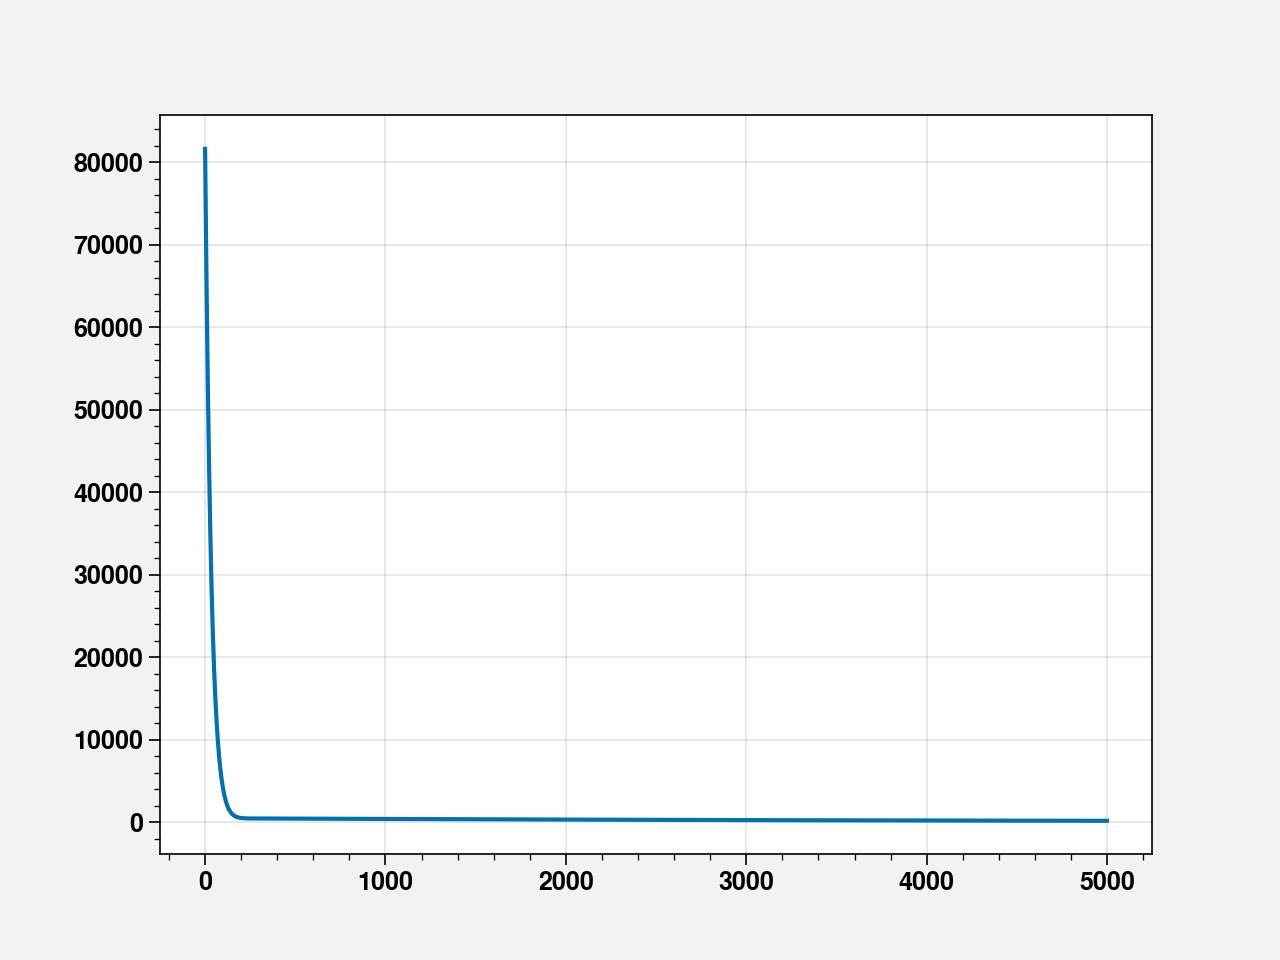

In [7]:
def summary(samples, prob=0.95):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0).data.numpy(),
            "std": torch.std(v, 0).data.numpy(),
            "{:.1f}%".format(100 * (1 - prob)): v.kthvalue(
                int(len(v) * (1 - prob)), dim=0
            )[0].data.numpy(),
            "{:.1f}%".format(100 * prob): v.kthvalue(int(len(v) * prob), dim=0)[
                0
            ].data.numpy(),
        }
    return pd.DataFrame(site_stats)


conditioned = pyro.condition(model, data={"kcal_per_g": kcal_per_g})
guide = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned,
    guide=guide,
    optim=pyro.optim.Adam({"lr": 0.005}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(neocortex_perc, kcal_per_g) for t in range(num_steps)]
plt.plot(losses)

# then train svi
laplace_guide = guide.laplace_approximation(neocortex_perc, kcal_per_g)
pred = pyro.infer.Predictive(laplace_guide, num_samples=1000)

# Code 5.21

In [42]:
pred_summary55 = summary(pred.get_samples())
pred_summary55

,_AutoMultivariateNormal_latent,a,bn,sigma
mean,"[32.788208, -0.47193605, 0.84538764]",32.78821,-0.4719358,0.67898583
std,"[5.731829, 0.08422364, 0.7763272]",5.731829,0.08422364,0.15295139
5.0%,"[23.16502, -0.61405104, -0.42165428]",23.16502,-0.61405104,0.39612097
95.0%,"[42.26315, -0.33265847, 2.1319087]",42.26315,-0.33265847,0.893966


# Code 5.22

In [13]:
pred_summary55.loc["mean", "bn"] * (76-55)

-9.954144716262817

# Code 5.23

# Code 5.24

In [14]:
dcc['log_mass'] = np.log(dcc['mass'])

# Code 5.25

,_AutoMultivariateNormal_latent,a,bn,sigma
mean,"[-47.76406, 0.7114209, 1.2472878]",-47.764095,0.7114205,0.77532977
std,"[4.2788386, 0.06288167, 0.17764814]",4.2788386,0.06288167,0.030734725
5.0%,"[-54.999214, 0.60716826, 0.9598306]",-54.999214,0.60716826,0.7230879
95.0%,"[-40.707684, 0.8153374, 1.542253]",-40.707684,0.8153374,0.823792


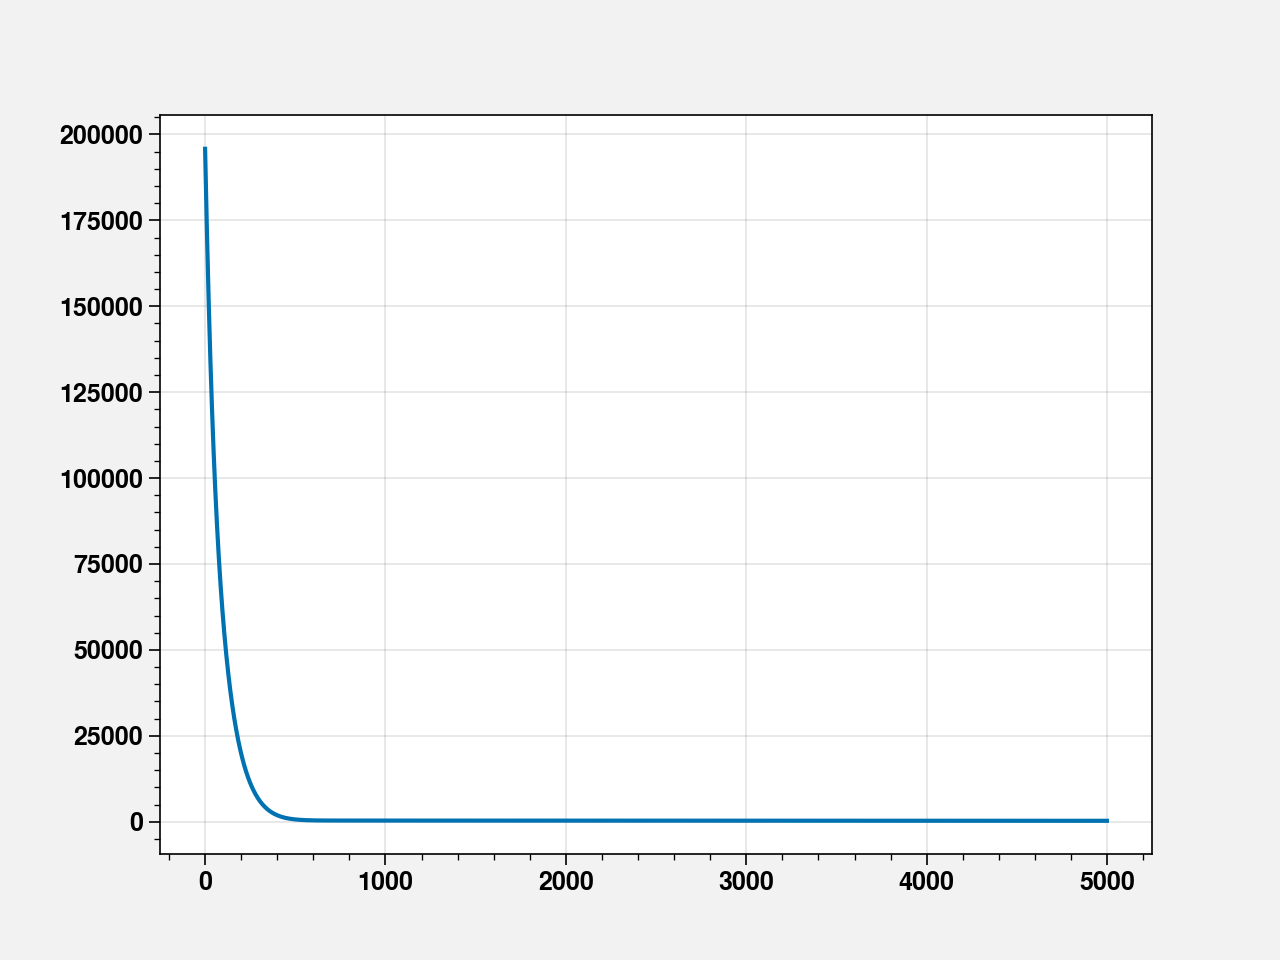

In [26]:
def model56(logmass, kcal):
  a = pyro.sample("a", dist.Normal(0, 100))
  bm = pyro.sample("bn", dist.Normal(0, 1))
  sigma = pyro.sample("sigma", dist.Uniform(0, 1))

  mu = a + bm * logmass
  pyro.sample("kcal_per_g", dist.Normal(mu, sigma))

kcal_per_g = tensor(dcc['kcal.per.g'], dtype=torch.float)
neocortex_perc = tensor(dcc['neocortex.perc'], dtype=torch.float)

conditioned56 = pyro.condition(model56, data={"kcal_per_g": kcal_per_g})
guide56 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned56)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned56,
    guide=guide56,
    optim=pyro.optim.Adam({"lr": 0.005}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(neocortex_perc, kcal_per_g) for t in range(num_steps)]
plt.plot(losses)

laplace_guide56 = guide56.laplace_approximation(neocortex_perc, kcal_per_g)
pred56 = pyro.infer.Predictive(laplace_guide56, num_samples=1000)  
precis56 = summary(pred56.get_samples()) 

precis56

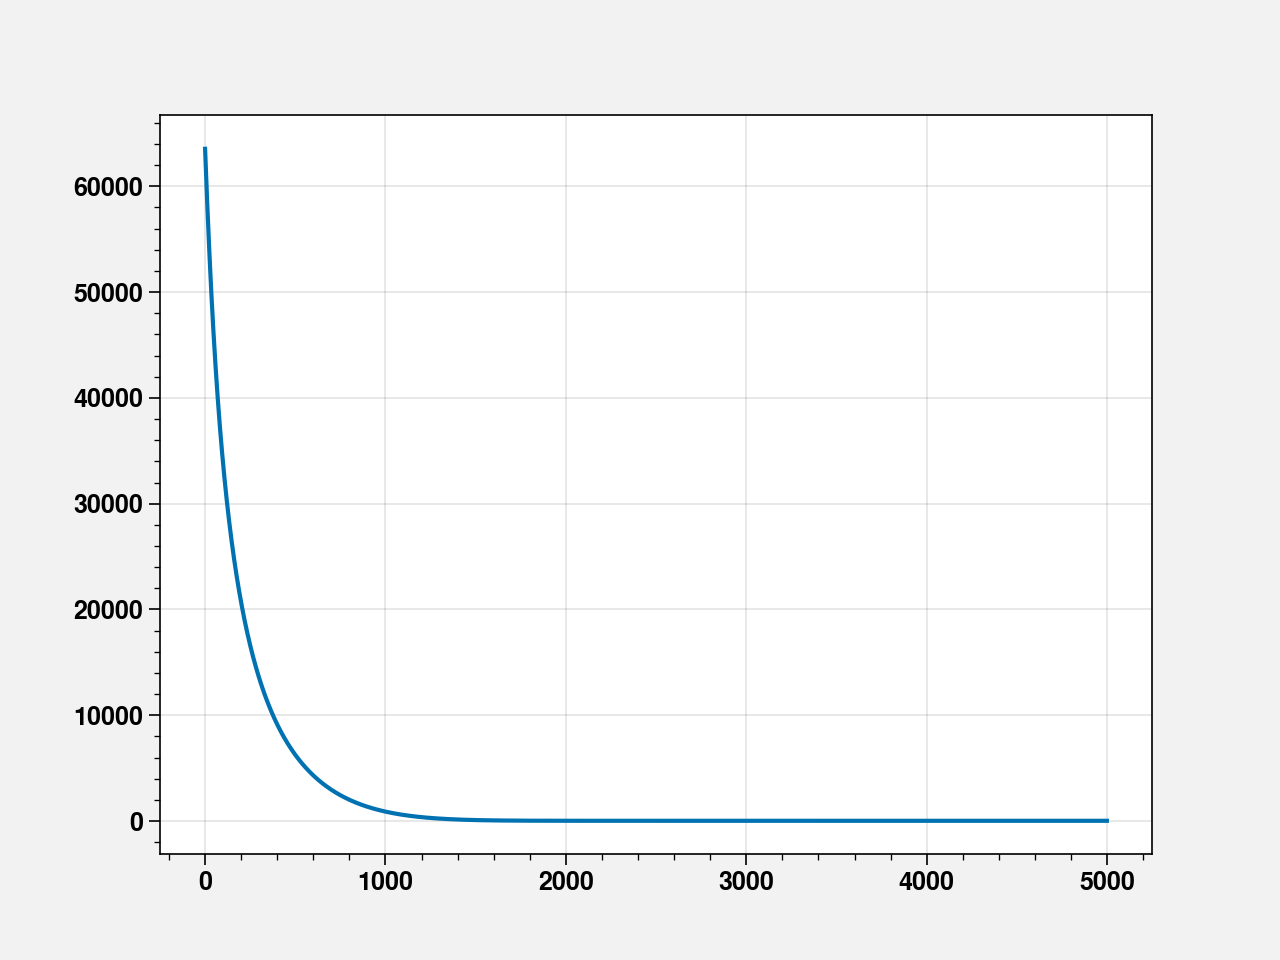

In [36]:
def model56(logmass, kcal):
  a = pyro.sample("a", dist.Normal(tensor(0.), tensor(100.)))
  bm = pyro.sample("bm", dist.Normal(tensor(0.), tensor(1.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(1.)))

  mu = a + bm * logmass
  #print(mu)
  kcal_per_g = pyro.sample("kcal_per_g", dist.Normal(mu.float(), sigma.float()))
  return kcal_per_g


def guide56(logmass, kcal):
  a_param = pyro.param("a_param", tensor(10.))
  bm_param = pyro.param("bm_param", tensor(.5))
  sigma_param = pyro.param("sigma_param", tensor(.5))
  return pyro.sample("a", dist.Delta(a_param)), pyro.sample("bm", dist.Delta(bm_param)),  pyro.sample("sigma", dist.Delta(sigma_param))


conditioned56 = pyro.condition(model56, data={"kcal_per_g": kcal_per_g})
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned56,
    guide=guide56,
    optim=pyro.optim.Adam({"lr": 0.001}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(neocortex_perc, kcal_per_g) for t in range(num_steps)]
plt.plot(losses)


In [38]:
pyro.param("bm_param")

tensor(-0.1276, requires_grad=True)

In [30]:
pyro.param("a")

KeyError: ignored

In [ ]:



kcal_per_g = tensor(dcc['kcal.per.g'], dtype=torch.float)
neocortex_perc = tensor(dcc['neocortex.perc'], dtype=torch.float)


guide56 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned56)
pyro.clear_param_store()

svi = pyro.infer.SVI(
    model=conditioned56,
    guide=guide56,
    optim=pyro.optim.Adam({"lr": 0.005}),
    loss=pyro.infer.Trace_ELBO(),
)
num_steps = 5000
losses = [svi.step(neocortex_perc, kcal_per_g) for t in range(num_steps)]
plt.plot(losses)

laplace_guide56 = guide56.laplace_approximation(neocortex_perc, kcal_per_g)
pred56 = pyro.infer.Predictive(laplace_guide56, num_samples=1000)  
precis56 = summary(pred56.get_samples()) 

precis56

# Code 5.26

# Code 5.27

# Code 5.28

# Code 5.29

In [46]:
N = 100
height = dist.Normal(10., 2.).rsample(torch.Size([N]))
leg_prop = dist.Uniform(0.4, 0.5).rsample(torch.Size([N]))

leg_left = leg_prop*height + dist.Normal(0., 0.02).rsample(torch.Size([N]))
leg_right = leg_prop*height + dist.Normal(0., 0.02).rsample(torch.Size([N]))

d = pd.DataFrame([height, leg_left, leg_right]).T
d.columns = ['height', 'leg_left', 'leg_right']
d['leg_left']


0     tensor(3.2916)
1     tensor(3.7189)
2     tensor(2.5955)
3     tensor(3.7197)
4     tensor(4.6829)
           ...      
95    tensor(2.4644)
96    tensor(3.8507)
97    tensor(5.5486)
98    tensor(4.2952)
99    tensor(5.6976)
Name: leg_left, Length: 100, dtype: object

# Code 5.30

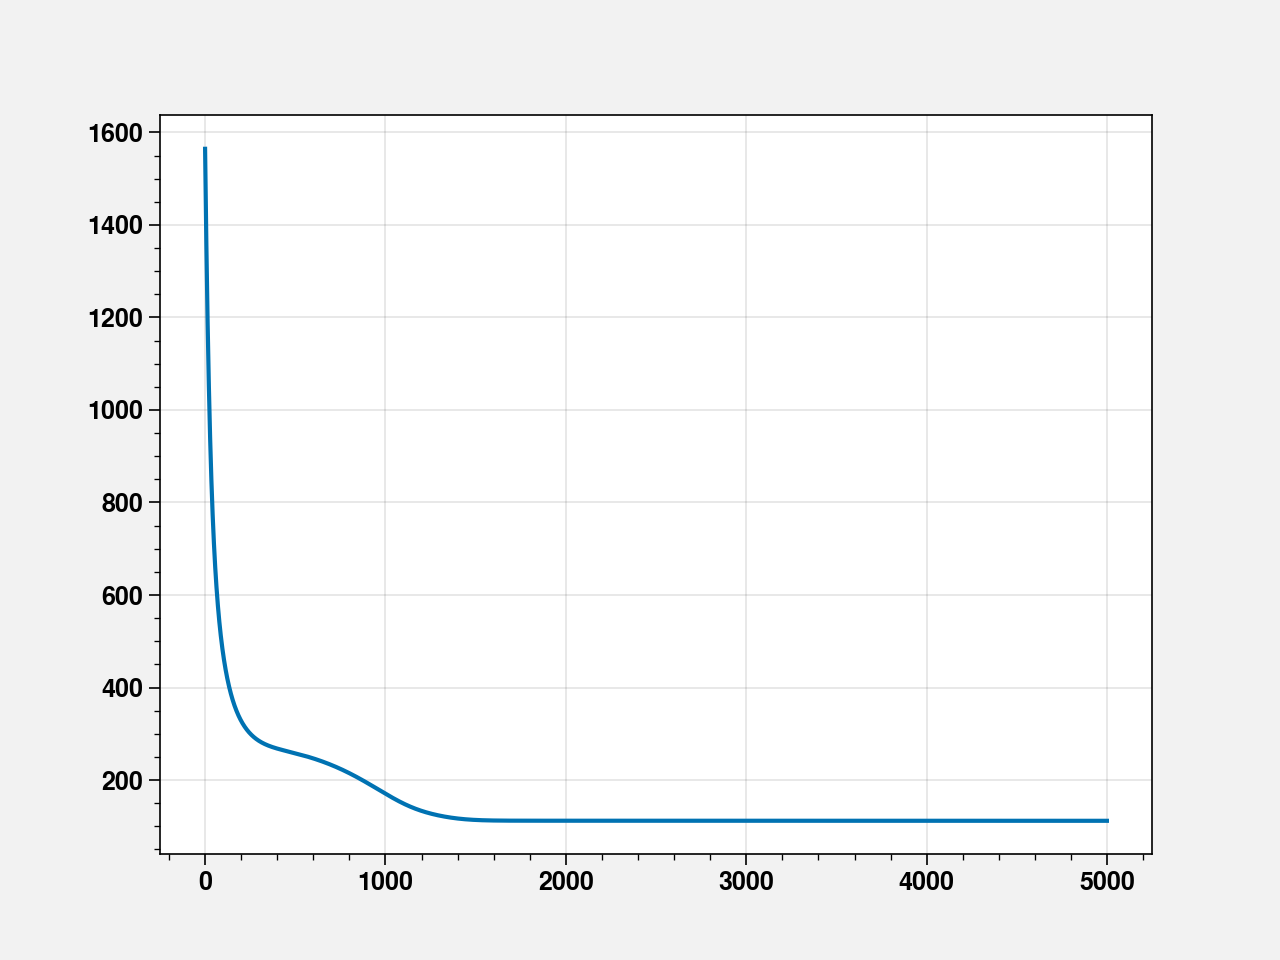

In [55]:
def model58(ll, lr):
  a = pyro.sample("a", dist.Normal(tensor(10.), tensor(100.)))
  bl = pyro.sample("bl", dist.Normal(tensor(2.), tensor(10.)))
  br = pyro.sample("br", dist.Normal(tensor(2.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))

  mu = a + bl*ll + br*lr
  height = pyro.sample("height", dist.Normal(mu, sigma))
  return height


conditioned58 = pyro.condition(model58, data={"height": tensor(height, dtype=torch.float)})
guide58 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned58)
pyro.clear_param_store()

svi = pyro.infer.SVI(model=conditioned58,
                     guide=guide58,
                     optim=pyro.optim.Adam({"lr": 0.01}),
                     loss=pyro.infer.Trace_ELBO())
num_steps = 5000
losses = [svi.step(tensor(leg_left, dtype=torch.float), tensor(leg_right, dtype=torch.float)) for t in range(num_steps)]
plt.plot(losses)

laplace_guide58 = guide58.laplace_approximation(tensor(leg_left, dtype=torch.float), tensor(leg_right, dtype=torch.float))
pred58 = pyro.infer.Predictive(laplace_guide58, num_samples=1000)  
precis58 = summary(pred58.get_samples())

In [56]:
precis58

,_AutoMultivariateNormal_latent,a,bl,br,sigma
mean,"[0.87548476, 3.2208185, -1.2089413, -2.6803083]",0.8754845,3.2208164,-1.2089427,0.64302516
std,"[0.30118296, 2.0524733, 2.0609658, 0.07756041]",0.30118296,2.0524733,2.0609658,0.046642825
5.0%,"[0.36844343, -0.10402179, -4.6098514, -2.810456]",0.36844343,-0.10402179,-4.6098514,0.5676176
95.0%,"[1.3700272, 6.6020947, 2.185452, -2.5547223]",1.3700272,6.6020947,2.185452,0.7210987


# Code 5.34

,_AutoMultivariateNormal_latent,a,bl,sigma
mean,"[0.87482226, 2.013322, -2.6876388]",0.874822,2.0133207,0.6386014
std,"[0.30229595, 0.0661496, 0.076761425]",0.30229595,0.0661496,0.045915317
5.0%,"[0.3920303, 1.9123733, -2.816843]",0.3920303,1.9123733,0.5642077
95.0%,"[1.347035, 2.1199315, -2.5651648]",1.347035,2.1199315,0.71414286


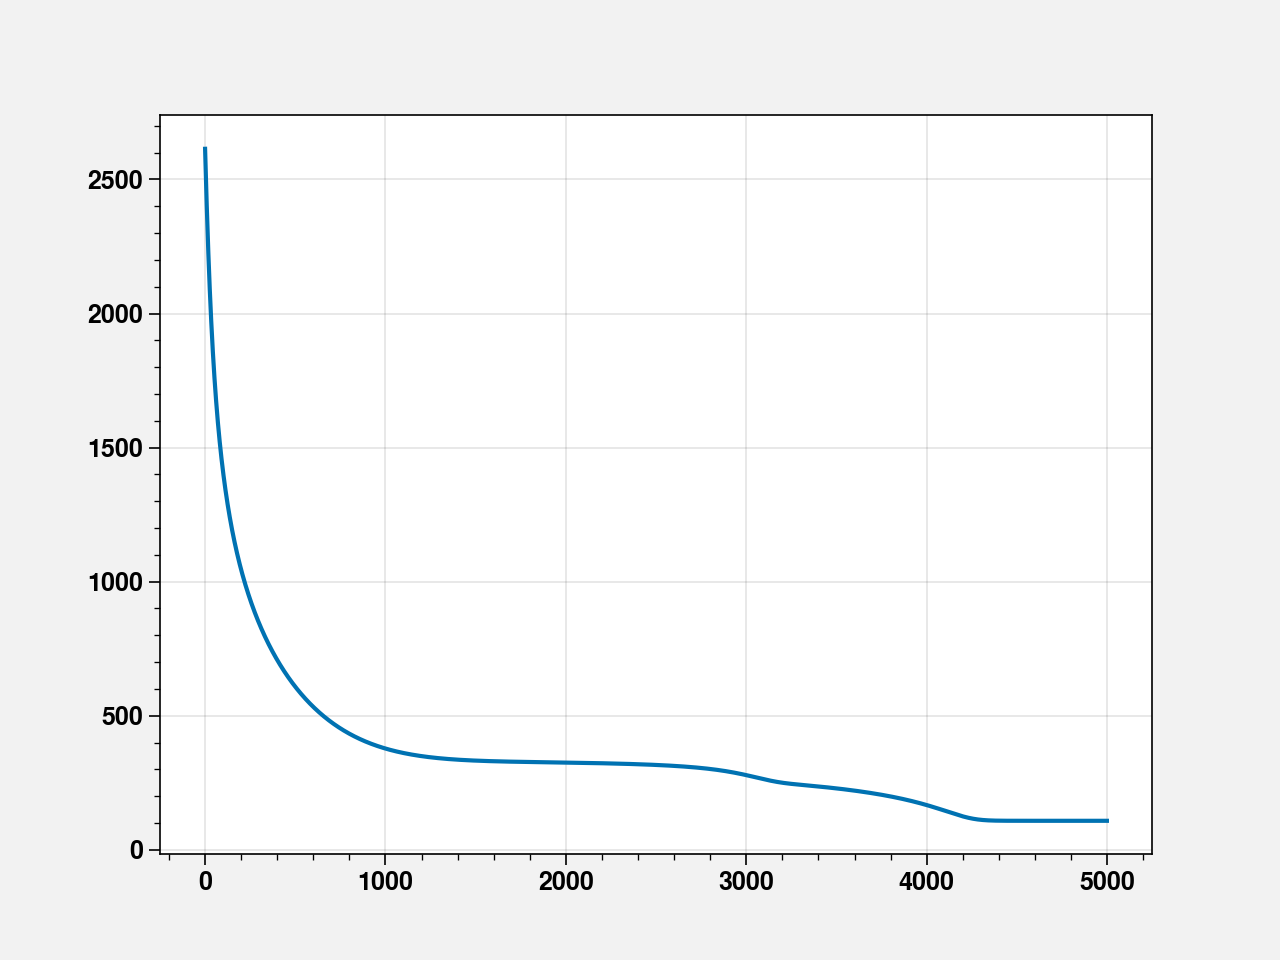

In [59]:
def model59(ll):
  a = pyro.sample("a", dist.Normal(tensor(10.), tensor(100.)))
  bl = pyro.sample("bl", dist.Normal(tensor(2.), tensor(10.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))

  mu = a + bl*ll
  height = pyro.sample("height", dist.Normal(mu, sigma))
  return height


conditioned59 = pyro.condition(model59, data={"height": tensor(height, dtype=torch.float)})
guide59 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned59)
pyro.clear_param_store()

svi = pyro.infer.SVI(model=conditioned59,
                     guide=guide59,
                     optim=pyro.optim.Adam({"lr": 0.01}),
                     loss=pyro.infer.Trace_ELBO())
num_steps = 5000
losses = [svi.step(tensor(leg_left, dtype=torch.float)) for t in range(num_steps)]
plt.plot(losses)

laplace_guide59 = guide59.laplace_approximation(tensor(leg_left, dtype=torch.float))
pred59 = pyro.infer.Predictive(laplace_guide59, num_samples=1000)  
precis59 = summary(pred59.get_samples())
precis59

# Code 5.35

In [60]:
milk_df = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv", sep=";")
d = milk_df 
dmilk_df = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/milk.csv", sep=";")
d = milk_df 
d

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN
5,New World Monkey,Alouatta seniculus,0.47,21.22,23.58,55.20,5.25,64.54
6,New World Monkey,A palliata,0.56,29.66,23.46,46.88,5.37,64.54
7,New World Monkey,Cebus apella,0.89,53.41,15.80,30.79,2.51,67.64
8,New World Monkey,Saimiri boliviensis,0.91,46.08,23.34,30.58,0.71,NaN
9,New World Monkey,S sciureus,0.92,50.58,22.33,27.09,0.68,68.85


# Code 5.36

,_AutoMultivariateNormal_latent,a,bf,sigma
mean,"[0.30144212, 0.010325772, -4.575703]",0.3014422,0.010325772,0.10354535
std,"[0.050782613, 0.0013959599, 0.17989376]",0.050782613,0.0013959599,0.018477598
5.0%,"[0.2186079, 0.00786147, -4.8623204]",0.2186079,0.00786147,0.076731876
95.0%,"[0.38545594, 0.012558104, -4.282133]",0.38545594,0.012558104,0.13624963


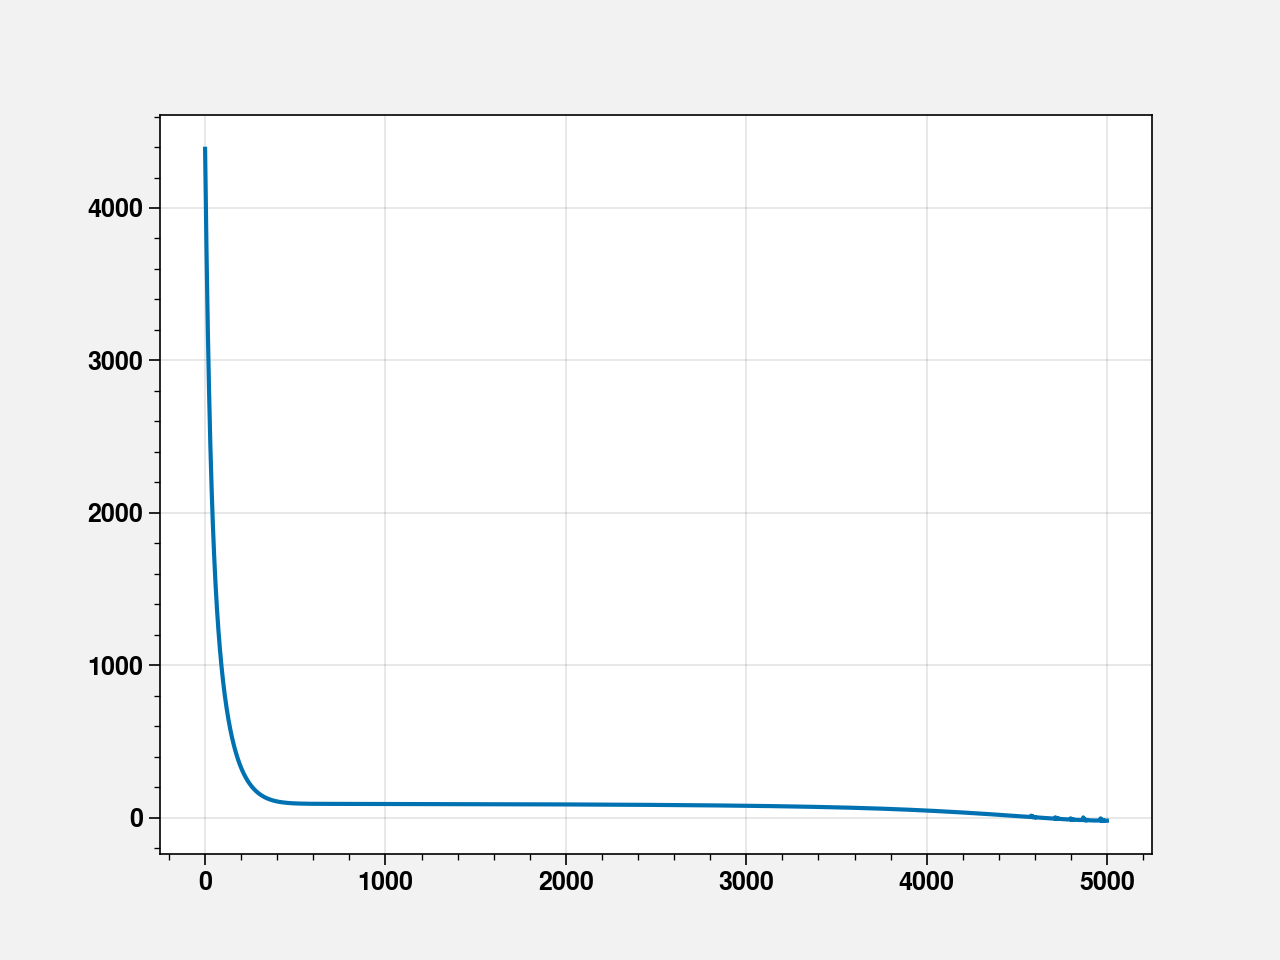

In [63]:
def model510(pf):
  a = pyro.sample("a", dist.Normal(tensor(0.6), tensor(10.)))
  bf = pyro.sample("bf", dist.Normal(tensor(2.), tensor(1.)))
  sigma = pyro.sample("sigma", dist.Uniform(tensor(0.), tensor(10.)))

  mu = a + bf*pf
  kcal_per_g = pyro.sample("kcal_per_g", dist.Normal(mu, sigma))
  return height


conditioned510 = pyro.condition(model510, data={"kcal_per_g": tensor(d['kcal.per.g'], dtype=torch.float)})
guide510 = pyro.infer.autoguide.AutoLaplaceApproximation(conditioned510)
pyro.clear_param_store()

svi = pyro.infer.SVI(model=conditioned510,
                     guide=guide510,
                     optim=pyro.optim.Adam({"lr": 0.01}),
                     loss=pyro.infer.Trace_ELBO())
num_steps = 5000
losses = [svi.step(tensor(d['perc.fat'], dtype=torch.float)) for t in range(num_steps)]
plt.plot(losses)

laplace_guide510 = guide510.laplace_approximation(tensor(d['perc.fat'], dtype=torch.float))
pred510 = pyro.infer.Predictive(laplace_guide510, num_samples=1000)  
precis510 = summary(pred510.get_samples())
precis510

# Code 5.37

# Code 5.38

# Code 5.39

# Code 5.40

# Code 5.41


# Code 5.42

# Code 5.43

# Code 5.44

# Code 5.45

# Code 5.46

# Code 5.47

# Code 5.48

# Code 5.49

# Code 5.50

# Code 5.51


# Code 5.52

# Code 5.53

# Code 5.54

# Code 5.55

# Code 5.56

# Code 5.57

# Code 5.58

# Code 5.59

# Code 5.60

# Code 5.61

# Code 5.62